In [1]:
from snpy import *
import numpy as np

import random
import os
import statistics as stats
import matplotlib.pyplot as plt
from astropy.table import Table
import glob
from os import remove
from astropy.cosmology import FlatLambdaCDM

from scipy.stats import kde
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import curve_fit

In [2]:
#FUNCIONES DE LA SIMULACIÓN#
############################

#Función lector de txt
def lector(a,sn,bandJ,bandH):
    with open(a, 'r') as f: #Abrimos archivo en modo lectura (r)
        vJ=vH=k=0 #Objetos de apoyo
        for line in f:  #Leo cada linea del txt
            if (line.find('f'))==0: #Si se cumple estamos en una linea 'filter _'
                if line == 'filter J\n':        #Así se cuando el archivo está leyendo datos...
                    vJ=1 #'Activo' el objeto de band J
                    vH=0 #'Desactivo' el de band H
                elif line == 'filter H\n':      #...de los filtros J y H respectivamente
                    vH=1 #Viceversa
                    vJ=0
                else:
                    vH=vJ=0 #'Desactivo' ambos pues estamos en otros filtros       
            if vJ==1:
                bandJ.append(k) #Guardo la posición del Filter J
            if vH==1:
                bandH.append(k) #Guardo la posición del Filter H
            sn.append(line)
            k=k+1
            
#Actualización de aleatorio                       
def aleatorio2(a,sn,bandJ,bandH,n1,n2,sTmax,temporal2): 
    for n in n1:
        for num2 in range(n2):
            import random
            x='txt/z2_RNDM_'+ str(n) +'_'+ str(num2) +'_'+ a
            taux=[]
            ranJ=[]
            ranH=[]
            with open(x, 'w') as f:
                maxj=bandJ[len(bandJ)-1]
                maxh=bandH[len(bandH)-1]
                minj=bandJ[1]
                minh=bandH[1]
                k=0
                ######## Si num2 es par buscamos primero en J ##### 
                if num2 % 2 == 0:
                    #Generamos los numeros aletarios dentro del rango de J
                    ranJ=random.sample(bandJ[1:],n)                    
                    for i in range(len(ranJ)): #Ciclo sobre el número de datos generados en J
                        taux.append(float(sn[ranJ[i]][0:7])) #Guardo el t de cada dato
                        for j in range(len(bandH)-1):
                            if sn[ranJ[i]][0:7]==sn[minh+j][0:7]: #Se busca un elemento con ==t que el J en H
                                ranH.append(minh+j) #Añadir elemento al final de la lista
                                break
                else:######## Si num2 es impar buscamos primero en H ####### Así compensamos que no sean siempre los puntos J los mayoritarios
                    #Generamos los numeros aletarios dentro del rango de J
                    ranH=random.sample(bandH[1:],n)
                    for i in range(len(ranH)): #Ahora para rango de H
                        taux.append(float(sn[ranH[i]][0:7]))
                        for j in range(len(bandJ)-1):
                            if sn[ranH[i]][0:7]==sn[minj+j][0:7]: 
                                ranJ.append(minj+j) #Añadir elemento al final de la lista
                                break
                temporal2.append(taux) #guardo la lista de los t de (n,num2) en la matriz de tiempos
                #### Los escribimos en el txt ####   
                for line in sn:
                    if k in range(minj,maxj+1):#Esta en el rango de filtro J
                        for i in range(len(ranJ)): #Comprobamos para toda la lista de aleatorios
                            if k==ranJ[i]: #Se escribe si es el nº de dato que buscamos
                                f.write(line)
                    elif k in range(minh,maxh+1): #Esta en el rango de filtro H            
                        for j in range(len(ranH)):  #Igual para H 
                            if k==ranH[j]: 
                                f.write(line)
                    else:    
                        f.write(line)  #se escriben los restantes
                    k=k+1      

#PUNTO A PUNTO: 1º Función-Escribe en un txt                     
def tiempo2(a,sn,bandJ,bandH):
    with open(a, 'w') as f:
        maxj=bandJ[len(bandJ)-1]
        maxh=bandH[len(bandH)-1]
        minj=bandJ[1]
        minh=bandH[1]
        global cJ,cH,j,h,cB #Las definimos como variables globales para poder cambiar su valor
        cJ2=cJ3=cH3=cB=0
        k=0
        for line in sn:
            
            if k in range(minj,maxj+1): ####Estamos dentro del rango de filtro J
                if j<len(bandJ) and h<len(bandH):
                    if cH==0 and cJ==0: #comprobamos control
                        if k==bandJ[j]:
                            if float(sn[bandJ[j]][0:7])<=float(sn[bandH[h]][0:7]): 
                                f.write(line) #Si date J es menor o igual que date H se escribe                            
                            else: 
                                cJ=1 #si no se ha escrito se activa la variable de control
                                cJ2=1
                                f.write(line)
                                cB=1 #Aunque escriba esta linea al activar cB será ignorada por snpy
                    else: 
                        if cH!=0: #Si no se ha escrito el H anterior (cH=1)
                            if k==bandJ[j+1]:
                                    if float(sn[bandJ[j+1]][0:7])==float(sn[bandH[h]][0:7]) and cJ3==0: #comprobamos si el siguiente J fue tomado en la misma fecha (y que no se ha escrito ya [cJ3])
                                        f.write(line)
                                        cJ3=1
                                        j=j+1
                                    else:
                                        if cJ3==0:
                                            f.write(line)
                                            cB=1
                        else: #EN este caso cJ==1 pero cH==0, no se escribió el J en el anterior ciclo, así que lo escribimos ahora
                            if k==bandJ[j]:
                                f.write(line)
                else:
                    if j>=len(bandH):
                        l=1  #No hace nada                     
                    else:
                        if h>=len(bandH) and k==bandJ[j]:
                            f.write(line)    
                            
            elif k in range(minh,maxh+1): ######Comprobamos que estamos dentro del rango de H
                if j<len(bandJ) and h<len(bandH):
                    if cJ==1 and cJ2==0: #Si no se ha escrito el J anterior (cJ=1) del ciclo anterior (cJ2==0)
                        if k==bandH[h+1]:
                            if float(sn[bandH[h+1]][0:7])==float(sn[bandJ[j]][0:7]) and cH3==0: #comprobamos si el siguiente H fue tomado en la misma fecha (y que no se ha escrito ya [cH3])
                                f.write(line)
                                cH3==1
                                h=h+1
                            else:
                                if cH3==0:
                                    f.write(line)
                                    cB=2
                            cJ=0
                    else:
                        if k==bandH[h]:
                            if cH==0:
                                if float(sn[bandH[h]][0:7])<=float(sn[bandJ[j]][0:7]):
                                    f.write(line) #Viceversa
                                else:
                                    cH=1 #idem control
                                    f.write(line)
                                    cB=2 #Aunque escriba esta linea al activar cB será ignorada por snpy
                            else: #Si H no fue escrito en el ciclo anterior lo escribimos directamente
                                f.write(line)
                                cH=0
                else:
                    if h>=len(bandH):
                        l=1
                    else:
                        if j>=len(bandJ) and k==bandH[h]:
                            f.write(line)  
            else:    
                f.write(line) #se escribe el resto de datos
            k=k+1

#PUNTO A PUNTO: 2º- Cambia el nombre de cada txt dependiendo de sus circunstancias (J solo, H solo, etc)
def tiempo3(b,sn,bandJ,bandH,sTmax,tiempo):
    global cJ,cH,j,h,cB,j1,j2
    j=h=1 #Necesario inicializar
    cJ=cH=cB=j1=0 #Variables de control
    #Ciclo necesario para ejecutar correctamente la función tiempo2
    for i in range(min([len(bandJ),len(bandH)])): 
        if j<(len(bandJ)-1) and h<(len(bandH)-1):
            if float(sn[bandJ[j]][0:7])<(sTmax+500.0) and float(sn[bandH[h]][0:7])<(sTmax+500.0):
                a='provisional'+str(i)+'.txt'
                prov2 = open(a, 'w')
                tiempo2(a,sn,bandJ,bandH)
                if cB!=0:
                    if cB==1: #Si se cumple quiere decir que no tenemos valor válido en la banda H
                        j1=j1+1 #Indica el número del fichero
                        j2.append(1) #Nos indica el tipo de fichero para cada posición j1
                        os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB1' +'_'+ b)
                        tiempo.append(float(sn[bandJ[j]][0:7])-sTmax) #Guarda el tiempo correspondiente al punto utilizado en el fichero
                        
                    if cB==2: #Si se cumple quiere decir que no tenemos valor válido en la banda J
                        j1=j1+1
                        j2.append(2)
                        os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB2' +'_'+ b)
                        tiempo.append(float(sn[bandH[h]][0:7])-sTmax)
                else:
                        j1=j1+1
                        j2.append(0)
                        os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB0' +'_'+ b)
                        tiempo.append(float(sn[bandJ[j]][0:7])-sTmax)
                        
                if cJ==1 or cH==1:
                    tiempo2(a,sn,bandJ,bandH)
                    if cB!=0:
                        if cB==1: #Si se cumple quiere decir que no tenemos valor válido en la banda H
                            j1=j1+1
                            j2.append(1)
                            os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB1' +'_'+ b)
                            tiempo.append(float(sn[bandJ[j]][0:7])-sTmax)
                            
                        if cB==2: #Si se cumple quiere decir que no tenemos valor válido en la banda J
                            j1=j1+1
                            j2.append(2)
                            os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB2' +'_'+ b)
                            tiempo.append(float(sn[bandH[h]][0:7])-sTmax)

                    else:
                            j1=j1+1
                            j2.append(0)
                            os.rename(a, 'txt/z1_2PT_'+ str(j1) +'_'+ 'cB0' +'_'+ b)
                            tiempo.append(float(sn[bandJ[j]][0:7])-sTmax)

            prov2.close()
            j=j+1
            h=h+1

#Genera todos los txt de n combinaciones posibles 
def combinatoria(indicador,a,n,comT):
    #Lee J y H
    sn, bandJ, bandH = ([] for i in range(3))
    lector(a,sn,bandJ,bandH)

    #'Elimina' de J los puntos que no tienen compañero en el tiempo
    conJ,conH,trH,tJ = ([] for i in range(4))
    minj,minh=bandJ[1],bandH[1]
    #Veo que puntos tienen el mismo T
    for i in range(len(bandJ)): #Ciclo sobre el número de datos en J
        for j in range(len(bandH)-1):
            if sn[bandJ[i]][0:7]==sn[minh+j][0:7]: #Se busca un elemento con ==t que el J en H
                conJ.append(bandJ[i])
                trH.append(minh+j) #Vector con las posiciones en H con puntos coincidentes en tiempo con J
                tJ.append(float(sn[bandJ[i]][0:7])) #Guardo el t de cada dato
                break

    #Genera el vector de combinaciones de J
    from itertools import combinations
    comJ,comH,aux = ([] for i in range(3))
    for combi in combinations(conJ, n):
        for ene in range(n):
            aux.append(combi[ene])
        comJ.append(aux)
        aux=[]
        
    #Transforma las posiciones de combJ en sus respectivos tiempos
    aux=[]
    for i in range(len(comJ)):
        for j in range(len(comJ[i])):
            k=conJ.index(comJ[i][j])
            aux.append(tJ[k])
        comT.append(aux)
        aux=[]
        
    if indicador==1:    
        #Elimina del vector de combinaciones las que ya se han realizado en aleatorio
        pdis=min([len(bandJ)-1,len(bandH)-1])
        n2=int((np.math.factorial(pdis)/(np.math.factorial(n)*np.math.factorial(pdis-n)))) #Número de repeticiones
        for num2 in range(n2):
                random='txt/z2_RNDM_'+ str(n) +'_'+ str(num2) +'_'+ a 
                sn1,bandJ2,bandJ1,bandH1,conX=([] for i in range(5))

                lector(random,sn1,bandJ2,bandH1)
                bandJ1=bandJ2[1:]
                for i in range(len(bandJ1)):
                    conX.append(float(sn1[bandJ1[i]][0:7]))
                try:
                    k=comT.index(conX)
                    comJ.pop(k)
                    comT.pop(k)
                except:
                    pass

    #Genera el vector con las combinaciones de H a partir de J
    aux = []
    for i in range(len(comJ)):
        for j in range(len(comJ[i])):
            k=conJ.index(comJ[i][j])
            aux.append(trH[k])
        comH.append(aux)
        aux=[]

    #Genera los txt a analizar
    for rep in range(len(comJ)):
        x='txt2/CMBN_'+ str(n) +'_'+ str(rep) +'_'+ a
        with open(x, 'w') as f:
            maxj=bandJ[len(bandJ)-1]
            maxh=bandH[len(bandH)-1]
            k=0
            #### Los escribimos en el txt ####   
            for line in sn:
                if k in range(minj,maxj+1):#Esta en el rango de filtro J
                    for i in range(len(comJ[rep])): #Comprobamos para toda la lista de aleatorios
                        if k==comJ[rep][i]: #Se escribe si es el nº de dato que buscamos
                            f.write(line)
                elif k in range(minh,maxh+1): #Esta en el rango de filtro H            
                    for j in range(len(comH[rep])):  #Igual para H 
                        if k==comH[rep][j]: 
                            f.write(line)
                else:    
                    f.write(line)  #se escriben los restantes
                k=k+1
    global rep1
    rep1=len(comJ)
            
#Generador de métricas
def genmet(n,n2,temporal2,metrica,sTmax):
    i=j=0 #Ciclo que recorre la matriz de t elemento a elemento
    for a1 in range(len(n)*n2): #Pasa por cada uno de los listas de la matriz
        metaux=[]
        sum1=0
        naux=n[i] #Número de elementos en la lista de posición i
        for a2 in range(naux): #Recorre esa lista elemento a elemento
            #Distance (1)
            sum1=abs(float(temporal2[a1][a2])-sTmax+sum1)
        j=j+1 #Sumamos una repitición de ese n (cada n se repite n2 veces)
        if j==n2: #Se ha repetido n2 veces
            j=0 #contador de repeticiones a cero
            i=i+1 #avanzamos al siguiente n 
        #Media
        metaux.append((stats.mean(temporal2[a1]))-sTmax)
        #Mediana 
        metaux.append(((stats.median(temporal2[a1])))-sTmax)
        #Range to peak 
        metaux.append((max(temporal2[a1])-sTmax)-(min(temporal2[a1])-sTmax))
        #Distance (2)
        metaux.append(sum1/naux)
        ##Todo se guarda en la matriz de métricas
        metrica.append(metaux)
        
#Escribe cada tipo de dato en su txt correspondiente
def datos(a,a1,s,i,tiempo,j3,met,n1,n2,maxm):
    if i==0: #Datos de referencia
        tipo=['spline','all-ebv','all-max','grJH-ebv','grJH-max']
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (s.Tmax, s.dm15, s.DM, s.EBVhost,maxm[0][0],maxm[0][1],maxm[1][0],maxm[1][1],tipo[j3]))
    elif i==8: #Datos de referencia max_model
        tipo=['spline','all-ebv','all-max','grJH-ebv','grJH-max']
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (s.Tmax, s.dm15, np.nan, np.nan, maxm[0][0], maxm[0][1], maxm[1][0], maxm[1][1],tipo[j3])) 
    elif i==1: #Datos de punto a punto
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\n' % (tiempo[j3], s.Tmax, s.dm15, maxm[0][0],maxm[0][1],maxm[1][0],maxm[1][1]))
    elif i==2: #Gnerar txt para aleatorio
        global b2
        b2='resultados/'+a1+'_ale-'+str(n2)+'.txt'
        with open(b2, 'w') as f:
            f.write('%10.5s\t%10.7s\t%10.5s\t%10.8s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.6s\t%10.6s\n'%('Media','Mediana','Range','Distance','Tmax','dm15','Jmax','Hmax','Tmax-J','Tmax-H'))       
    elif i==3: #Datos aleatorio
        with open(b2, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\n' % 
                    (met[n1][0],met[n1][1],met[n1][2], met[n1][3],s.Tmax, s.dm15,maxm[0][0],maxm[0][1],maxm[1][0],maxm[1][1]))
    elif i==4: #Sim conjunta
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % 
                    (tiempo[j3], maxm[0][0]-met[0][0], maxm[0][0]-met[0][1], maxm[0][0]-met[0][2],maxm[0][0]-met[0][3],maxm[0][0]-met[0][4], maxm[0][1]-met[1][0],maxm[0][1]-met[1][1],maxm[0][1]-met[1][2],maxm[0][1]-met[1][3],maxm[0][1]-met[1][4],s.name))
    elif i==5: #Sim conjunta aleatorio
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % 
                    (j3[n1][0], maxm[0][0]-met[0][0], maxm[0][0]-met[0][1], maxm[0][0]-met[0][2],maxm[0][0]-met[0][3],maxm[0][0]-met[0][4], maxm[0][1]-met[1][0],maxm[0][1]-met[1][1],maxm[0][1]-met[1][2],maxm[0][1]-met[1][3],maxm[0][1]-met[1][4],s.name))
    elif i==6: #Diagrama de Hubble
        with open(a, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.9s\n' % (maxm[0][0],s.z,s.name))
    elif i==7: #Epocas aleatorio
        with open(a, 'a') as f:
            for j in range(len(tiempo)):
                for k in range(n1):
                    f.write('%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (tiempo[j][k],j+1,n1,s.name))
    elif i==9: #Gnerar txt para aleatorio
        global b221
        b221='resultados/'+a1+'_cmb-'+str(n2)+'.txt'
        with open(b221, 'w') as f:
            f.write('%10.5s\t%10.7s\t%10.5s\t%10.8s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.6s\t%10.6s\n'%('Media','Mediana','Range','Distance','Tmax','dm15','Jmax','Hmax','Tmax-J','Tmax-H')) 
    elif i==10: #Datos combinatoria
        with open(b221, 'a') as f:
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\n' % 
                    (met[n1][0],met[n1][1],met[n1][2], met[n1][3],s.Tmax, s.dm15,maxm[0][0],maxm[0][1],maxm[1][0],maxm[1][1]))

            
#Busca el máximo y el mínimo del tiempo en bandJ y bandH
#se usará en gráficas
def mx(sn,bandJ,bandH,sTmax,mn):
    bJ=[]
    bH=[]
    mn1=[]
    for i in range(len(bandJ)):
        if i!=0:
            bJ.append(sn[bandJ[i]][0:7])
    for i in range(len(bandH)):
        if i!=0:
            bH.append(sn[bandH[i]][0:7])
    mn.append(float(max(max(bJ),max(bH)))-sTmax)
    mn.append(float(min(min(bJ),min(bH)))-sTmax)
    
#Determina la dispersion de los datos en sim        
def dispersion(i,dia,jm1,jm12):
    if i==0: #dispersion general
        media=np.nanmean(jm1)
        disp=np.nanstd(jm1)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==2: #dispersion -10 y 20 dias
        jm13=[]
        con1=0
        for day in dia:
            if day>=-10.0 and day<=20.0:
                jm13.append(jm1[con1])
            con1=con1+1
        media=np.nanmean(jm13)
        disp=np.nanstd(jm13)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==3: #dispersion -5 y 5 dias
        jm13=[]
        con1=0
        for day in dia:
            if day>=-5.0 and day<=10.0:
                jm13.append(jm1[con1])
            con1=con1+1
        media=np.nanmean(jm13)
        disp=np.nanstd(jm13)
        jm12.append([media,media])
        jm12.append(media-disp)
        jm12.append(media+disp)
        jm12.append(round(disp,3))
    elif i==1: #Buscamos máximo y mínimo valor en t  
        jm12.append(min(jm1))
        jm12.append(max(jm1))  
                                   
#Guarda en un vector el formato necesario de TmaxJ/H y J/HMax para cada situación
def maxJH(i,s,sTmax,maxm):
    maxm.clear()
    if i==0: #J y H  (Ref: SPLINE)
        maxm1=s.get_max(['J','H'])
        maxm.append([maxm1[1][0],maxm1[1][1]])
        maxm.append([maxm1[0][0]-sTmax,maxm1[0][1]-sTmax])
    elif i==1: #Ni J ni H
        maxm.append([np.nan,np.nan])
        maxm.append([np.nan,np.nan])
    elif i==2: #Si J, No H 
        maxm1=s.get_max('J')
        maxm.append([maxm1[1],np.nan])
        maxm.append([maxm1[0]-sTmax,np.nan])
    elif i==3: #No J, Si H 
        maxm1=s.get_max('H')
        maxm.append([np.nan,maxm1[1]])
        maxm.append([np.nan,maxm1[0]-sTmax])       
    elif i==4: #J y H  (Ref: AJUSTE [no spline])
        maxm1=s.model.get_max(['J','H'])
        maxm.append([maxm1[1][0],maxm1[1][1]])
        maxm.append([maxm1[0][0]-sTmax,maxm1[0][1]-sTmax])

#Guarda referencias en todas las bandas para allbands en un vector de vectores       
def maxJH2(s,sTmax,ref2,band1): 
    maxm2=[]
    prueba=s.get_max(band1)
    for i in range(len(prueba[3])):
        maxm2.append(prueba[3][i])
        maxm2.append(prueba[0][i]-sTmax)
        maxm2.append(prueba[1][i])
        ref2.append(maxm2)
        maxm2=[]
        
#Trata los archivos generados con s.dump_lc()        
def dump(i,s,band1,j3): 
    s.dump_lc()
    borrar=[]
    dump1=[]
    name=s.name
    tipos=['data','model','smooth']
    if i==0: #Para datos de allbands
        for i in band1: #Leemos todos los tipos de range de la supernova
            if i!='J' and i!='H': #Los que no son J y H
                for j in tipos: #Se guardan en el vector para borrarlos
                    borrar.append(s.name+'_lc_'+i+'_'+j+'.dat')
            else:
                for j in tipos: #J y H se guardan en el vector para moverlos de carpeta
                    dump1.append(s.name+'_lc_'+i+'_'+j+'.dat')
        for i in dump1: #Cambia a la carpeta txt los de J y Ht
            try:
                os.rename(i, "txt/"+i[4:])
            except:
                pass
            
    elif i==1: #Para datos de grJH
        for i in band1: #Leemos todos los tipos de range de la supernova
            if i!='J' and i!='H': #Los que no son J y H
                for j in tipos: #Se guardan en el vector para borrarlos
                    borrar.append(s.name+'_lc_'+i+'_'+j+'.dat')
            else:
                for j in tipos: #J y H se guardan en el vector para moverlos de carpeta
                    if j=='model':
                        dump1.append(s.name+'_lc_'+i+'_'+j+'.dat') #guardamos el data
                    else:
                        borrar.append(s.name+'_lc_'+i+'_'+j+'.dat') #los demás se borran
        for i in dump1: #Cambia a la carpeta txt los de J y H
            i1=i[4:int(len(i)-4)]
            try:
                os.rename(i, "txt/"+i1+'_grJH'+'.dat')
            except:
                pass
            
    elif i==2: #Para datos de grJH(1 punto)
        for i in band1: #Leemos todos los tipos de range de la supernova
            if i!='J' and i!='H': #Los que no son J y H
                for j in tipos: #Se guardan en el vector para borrarlos
                    borrar.append(s.name+'_lc_'+i+'_'+j+'.dat')
            else:
                for j in tipos: #J y H se guardan en el vector para moverlos de carpeta
                    if j=='model':
                        dump1.append(s.name+'_lc_'+i+'_'+j+'.dat') #guardamos el data
                    else:
                        borrar.append(s.name+'_lc_'+i+'_'+j+'.dat') #los demás se borran
        for i in dump1: #Cambia a la carpeta txt los de J y H
            i1=i[4:int(len(i)-4)]
            try:
                os.rename(i, "txt/"+i1+'_'+str(j3)+'.dat')
            except:
                pass

    elif i==3: #Para datos de allbands (max_model)
        for i in band1: #Leemos todos los tipos de range de la supernova
            if i!='J' and i!='H': #Los que no son J y H
                for j in tipos: #Se guardan en el vector para borrarlos
                    borrar.append(s.name+'_lc_'+i+'_'+j+'.dat')
            else:
                for j in tipos: #J y H se guardan en el vector para moverlos de carpeta
                    dump1.append(s.name+'_lc_'+i+'_'+j+'.dat')
        for i in dump1: #Cambia a la carpeta txt los de J y Ht
            i1=i[4:int(len(i)-4)]
            try:
                os.rename(i, "txt/"+i1+'_max'+'.dat')
            except:
                pass
                
    elif i==4: #Para datos de grJH (max_model)
        for i in band1: #Leemos todos los tipos de range de la supernova
            if i!='J' and i!='H': #Los que no son J y H
                for j in tipos: #Se guardan en el vector para borrarlos
                    borrar.append(s.name+'_lc_'+i+'_'+j+'.dat')
            else:
                for j in tipos: #J y H se guardan en el vector para moverlos de carpeta
                    if j=='model':
                        dump1.append(s.name+'_lc_'+i+'_'+j+'.dat') #guardamos el data
                    else:
                        borrar.append(s.name+'_lc_'+i+'_'+j+'.dat') #los demás se borran
        for i in dump1: #Cambia a la carpeta txt los de J y H
            i1=i[4:int(len(i)-4)]
            try:
                os.rename(i, "txt/"+i1+'_grJH'+'_max'+'.dat')
            except:
                pass
            
    for k in borrar: #Borra los txt innecesarios
            #os.rename(k)
            try:
                os.remove(k)
            except:
                pass
                            
#Genera el vector de referencias
def referencias(i,c,ref):  
    global sTmax
    sim=[]
    sim = Table.read(c, format='ascii')
    if i==0:
        #Se ordena el txt de ref
        with open(c, 'w') as f:
            f.write('%10.5s\t%10.5s\t%10.5s\t%10.7s\t%10.5s\t%10.5s\t%10.6s\t%10.6s\t%10.6s\n' % ('Tmax','dm15','DM','EBVhost','Jmax','Hmax','Tmax-J','Tmax-H','Tipo'))
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (sim[0][0],sim[0][1],sim[0][2],sim[0][3],sim[0][4],sim[0][5],sim[0][6],sim[0][7],sim[0][8])) #allbands-ebv
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (sim[2][0],sim[2][1],sim[2][2],sim[2][3],sim[2][4],sim[2][5],sim[2][6],sim[2][7],sim[2][8])) #gr (spline en JHmax)
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (sim[3][0],sim[3][1],sim[3][2],sim[3][3],sim[3][4],sim[3][5],sim[3][6],sim[3][7],sim[3][8])) #grJH-ebv
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (sim[1][0],sim[1][1],sim[1][2],sim[1][3],sim[1][4],sim[1][5],sim[1][6],sim[1][7],sim[1][8])) #allbands-max
            f.write('%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.5f\t%10.9s\n' % (sim[4][0],sim[4][1],sim[4][2],sim[4][3],sim[4][4],sim[4][5],sim[4][6],sim[4][7],sim[4][8])) #grJH-max
    elif i==1:
        #Se genera sTmax y ref61
        sTmax=sim[0][0]
        #¿ALL-EBV / SPLINE / grJH-EBV / ALL-MAX / grJH-MAX?
        ref.append([sim[1][4],sim[0][4],sim[2][4],sim[3][4],sim[4][4]])
        ref.append([sim[1][5],sim[0][5],sim[2][5],sim[3][5],sim[4][5]])
    elif i==2:
        sTmax=sim[0][0]
        
        

In [3]:
#FUNCIONES PARA ANALISIS DE DATOS#
##################################

#LECTOR DATOS COMBINATORIA
def datoscomb(n,dif):
    ep1,ep2,ep3,ep4,ep5=([] for i in range(5))
    dif1,dif2,dif3,dif4,dif5=([] for i in range(5))
    tn='resultados/tiempo(n='+str(n)+').txt'
    sim=Table.read(tn, format='ascii')
    for i in range(len(sim)):
        #sn.append(sim[i][0])
        ep1.append(sim[i][1])
        ep2.append(sim[i][2])
        ep3.append(sim[i][3])
        ep4.append(sim[i][4])
        ep5.append(sim[i][5])

    if n==2:
        for i in range(len(ep1)):
            dif1=[ep1[i],ep2[i]]
            dif.append(max(dif1)-min(dif1))
    elif n==3:
        for i in range(len(ep1)):
            dif1=abs(ep1[i]-ep2[i])+abs(ep1[i]-ep3[i])+abs(ep2[i]-ep3[i])
            dif.append((dif1)/3.0)
    elif n==5:
        for i in range(len(ep1)):
            dif1=abs(ep1[i]-ep2[i])+abs(ep1[i]-ep3[i])+abs(ep1[i]-ep4[i])+abs(ep1[i]-ep5[i])
            dif2=abs(ep2[i]-ep3[i])+abs(ep2[i]-ep4[i])+abs(ep2[i]-ep5[i])
            dif3=abs(ep3[i]-ep4[i])+abs(ep3[i]-ep5[i])
            dif4=abs(ep4[i]-ep5[i])
            dif5=dif1+dif2+dif3+dif4
            dif.append((dif5)/10.0) 
            
##LECTORES DATOS ALEATORIO
#######
#LECTOR ARCHIVO EPOCAS DE ALEATORIO [n=2]
def datosale2(dif):
    #Se lee el txt con TODOS los tiempos utilizados
    ep,ep1,ep2,sn1,sn2,m1,m2=([] for i in range(7))
    sns1,sns=[],[]
    epoca="resultados/"+"epocas.txt" 
    ep = Table.read(epoca, format='ascii')
    #obtiene lista de las sn utilizadas
    j=0
    for i in range(len(ep)):
        sns1.append(ep[i][3])
    sns.append(sns1[j])
    for i in range(len(sns1)):
        if sns1[i]!=sns1[j]:
            j=i
            sns.append(sns1[j]) #este vector indica que supernovas tuvieron problemas
    #se genera un vector con sus sTmax
    sT=[]
    for i in range(len(sns)):
        name=str(sns[i].strip())
        a1=name[int(len(name)-3):int(len(name))]
        c="resultados/"+a1+"_ref.txt"
        referencias(2,c,0)
        sT.append(sTmax)


    ##Se lee el txt con los tiempos que NO se pudieron utilizar
    fallo='resultados/fallidosAleatorio.log'
    fallos=Table.read(fallo, format='ascii')
    #Se trata este txt
    fallos1,snf,fallos3,mf=([] for i in range(4))
    j=0
    for i in range(len(fallos)):
        fallos1.append(fallos[i][2])
    snf.append(fallos1[j])
    for i in range(len(fallos1)):
        if fallos1[i]!=fallos1[j]:
            j=i
            snf.append(fallos1[j]) #este vector indica que supernovas tuvieron problemas
            mf.append(fallos3)
            fallos3=[]
        fallos3.append(fallos[i][0]+1.0)
    mf.append(fallos3) #este otro indica que repeticiones no se usaron de esas sn

    ##Teniendo en cuenta las restricciones se trata el txt de epocas
    for i in range(len(ep)):
        num1=sns.index(ep[i][3])
        Tmax=sT[num1]
        if ep[i][3].strip() in snf: #se comprueba que la sn haya tenido problemas
            num=snf.index(ep[i][3].strip())
            if ep[i][1] in mf[num]: #no se guardan las epocas que no pudieron ser analizadas
                pass
            else:
                if i%2==0:
                    m1.append(ep[i][1])  #Vector de nº de repeticion de cada epoca 
                    ep1.append(ep[i][0]-Tmax) #Vector de epocas
                    sn1.append(ep[i][3]) #Vectos nombre de sn para cada epoca
                else:
                    m2.append(ep[i][1])
                    ep2.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn2.append(ep[i][3])            
        else: #El resto de datos se guarda
            if i%2==0:
                m1.append(ep[i][1])
                ep1.append(ep[i][0]-Tmax) 
                sn1.append(ep[i][3])
            else:
                m2.append(ep[i][1])
                ep2.append(ep[i][0]-Tmax)
                sn2.append(ep[i][3])

    #Se obtiene la diferencia entre las dos epocas
    for i in range(len(ep1)):
        ep3=[ep1[i],ep2[i]]
        dif.append(max(ep3)-min(ep3))   
        
#LECTOR ARCHIVO EPOCAS DE ALEATORIO [n=3]
def datosale3(dif):
    #Se lee el txt con TODOS los tiempos utilizados
    ep,ep1,ep2,sn1,sn2,m1,m2=([] for i in range(7))
    ep3,sn3,m3=([] for i in range(3))
    sns1,sns=[],[]
    epoca="resultados/"+"epocas3.txt" 
    ep = Table.read(epoca, format='ascii')
    #obtiene lista de las sn utilizadas
    j=0
    for i in range(len(ep)):
        sns1.append(ep[i][3])
    sns.append(sns1[j])
    for i in range(len(sns1)):
        if sns1[i]!=sns1[j]:
            j=i
            sns.append(sns1[j]) #este vector indica que supernovas tuvieron problemas
    #se genera un vector con sus sTmax
    sT=[]
    for i in range(len(sns)):
        name=str(sns[i].strip())
        a1=name[int(len(name)-3):int(len(name))]
        c="resultados/"+a1+"_ref.txt"
        referencias(2,c,0)
        sT.append(sTmax)
        
    ##Se lee el txt con los tiempos que NO se pudieron utilizar
    fallo='resultados/fallidosAleatorio3.log'
    fallos=Table.read(fallo, format='ascii')
    #Se trata este txt
    fallos1,snf,fallos3,mf=([] for i in range(4))
    j=0
    for i in range(len(fallos)):
        fallos1.append(fallos[i][2])
    snf.append(fallos1[j])
    for i in range(len(fallos1)):
        if fallos1[i]!=fallos1[j]:
            j=i
            snf.append(fallos1[j]) #este vector indica que supernovas tuvieron problemas
            mf.append(fallos3)
            fallos3=[]
        fallos3.append(fallos[i][0]+1.0)
    mf.append(fallos3) #este otro indica que repeticiones no se usaron de esas sn

    ##Teniendo en cuenta las restricciones se trata el txt de epocas
    contador=0
    for i in range(len(ep)):
        num1=sns.index(ep[i][3])
        Tmax=sT[num1]
        if ep[i][3].strip() in snf: #se comprueba que la sn haya tenido problemas
            num=snf.index(ep[i][3].strip())
            if ep[i][1] in mf[num]: #no se guardan las epocas que no pudieron ser analizadas
                contador=0
                pass
            else:
                if contador==0:
                    m1.append(ep[i][1])  #Vector de nº de repeticion de cada epoca 
                    ep1.append(ep[i][0]-Tmax) #Vector de epocas
                    sn1.append(ep[i][3]) #Vectos nombre de sn para cada epoca
                    contador=contador+1
                elif contador==1:
                    m2.append(ep[i][1])
                    ep2.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn2.append(ep[i][3])     
                    contador=contador+1
                elif contador==2:
                    m3.append(ep[i][1])
                    ep3.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn3.append(ep[i][3]) 
                    contador=0
        else: #El resto de datos se guarda
            if contador==0:
                m1.append(ep[i][1])  #Vector de nº de repeticion de cada epoca 
                ep1.append(ep[i][0]-Tmax) #Vector de epocas
                sn1.append(ep[i][3]) #Vectos nombre de sn para cada epoca
                contador=contador+1
            elif contador==1:
                m2.append(ep[i][1])
                ep2.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn2.append(ep[i][3])     
                contador=contador+1
            elif contador==2:
                m3.append(ep[i][1])
                ep3.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn3.append(ep[i][3]) 
                contador=0

    #Se obtiene la diferencia entre las dos epocas
    dif1,dif2=([] for i in range(2))
    for i in range(len(ep1)):
        dif1=abs(ep1[i]-ep2[i])+abs(ep1[i]-ep3[i])+abs(ep2[i]-ep3[i])
        dif.append((dif1)/3.0)            

#LECTOR ARCHIVO EPOCAS DE ALEATORIO [n=5]
def datosale5(dif):
    ##Se lee el txt con TODOS los tiempos utilizados
    ep,ep1,ep2,sn1,sn2,m1,m2=([] for i in range(7))
    ep3,sn3,m3,ep4,sn4,m4,ep5,sn5,m5=([] for i in range(9))
    sns1,sns=[],[]
    epoca="resultados/"+"epocas5.txt" 
    ep = Table.read(epoca, format='ascii')
    #obtiene lista de las sn utilizadas
    j=0
    for i in range(len(ep)):
        sns1.append(ep[i][3])
    sns.append(sns1[j])
    for i in range(len(sns1)):
        if sns1[i]!=sns1[j]:
            j=i
            sns.append(sns1[j]) #este vector indica que supernovas tuvieron problemas
    #se genera un vector con sus sTmax
    sT=[]
    for i in range(len(sns)):
        name=str(sns[i].strip())
        a1=name[int(len(name)-3):int(len(name))]
        c="resultados/"+a1+"_ref.txt"
        referencias(2,c,0)
        sT.append(sTmax)
    ##Se lee el txt con los tiempos que NO se pudieron utilizar
    fallo='resultados/fallidosAleatorio5.log'
    fallos=Table.read(fallo, format='ascii')
    #Se trata este txt
    fallos1,snf,fallos3,mf=([] for i in range(4))
    j=0
    for i in range(len(fallos)):
        fallos1.append(fallos[i][2])
    snf.append(fallos1[j])
    for i in range(len(fallos1)):
        if fallos1[i]!=fallos1[j]:
            j=i
            snf.append(fallos1[j]) #este vector indica que supernovas tuvieron problemas
            mf.append(fallos3)
            fallos3=[]
        fallos3.append(fallos[i][0]+1.0)
    mf.append(fallos3) #este otro indica que repeticiones no se usaron de esas sn

    ##Teniendo en cuenta las restricciones se trata el txt de epocas
    contador=0
    for i in range(len(ep)):
        num1=sns.index(ep[i][3])
        Tmax=sT[num1]
        if ep[i][3].strip() in snf: #se comprueba que la sn haya tenido problemas
            num=snf.index(ep[i][3].strip())
            if ep[i][1] in mf[num]: #no se guardan las epocas que no pudieron ser analizadas
                contador=0
                pass
            else:
                if contador==0:
                    m1.append(ep[i][1])  #Vector de nº de repeticion de cada epoca 
                    ep1.append(ep[i][0]-Tmax) #Vector de epocas
                    sn1.append(ep[i][3]) #Vectos nombre de sn para cada epoca
                    contador=contador+1
                elif contador==1:
                    m2.append(ep[i][1])
                    ep2.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn2.append(ep[i][3])     
                    contador=contador+1
                elif contador==2:
                    m3.append(ep[i][1])
                    ep3.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn3.append(ep[i][3]) 
                    contador=contador+1
                elif contador==3:
                    m4.append(ep[i][1])
                    ep4.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn4.append(ep[i][3]) 
                    contador=contador+1
                elif contador==4:
                    m5.append(ep[i][1])
                    ep5.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                    sn5.append(ep[i][3]) 
                    contador=0
        else: #El resto de datos se guarda
            if contador==0:
                m1.append(ep[i][1])  #Vector de nº de repeticion de cada epoca 
                ep1.append(ep[i][0]-Tmax) #Vector de epocas
                sn1.append(ep[i][3]) #Vectos nombre de sn para cada epoca
                contador=contador+1
            elif contador==1:
                m2.append(ep[i][1])
                ep2.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn2.append(ep[i][3])     
                contador=contador+1
            elif contador==2:
                m3.append(ep[i][1])
                ep3.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn3.append(ep[i][3]) 
                contador=contador+1
            elif contador==3:
                m4.append(ep[i][1])
                ep4.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn4.append(ep[i][3]) 
                contador=contador+1
            elif contador==4:
                m5.append(ep[i][1])
                ep5.append(ep[i][0]-Tmax) #Un vector de epocas para cada dato (2 porque n=2)
                sn5.append(ep[i][3]) 
                contador=0

    #Se obtiene la diferencia entre las dos epocas
    dif1,dif2,dif3,dif4,dif5=([] for i in range(5))
    for i in range(len(ep1)):
        dif1=abs(ep1[i]-ep2[i])+abs(ep1[i]-ep3[i])+abs(ep1[i]-ep4[i])+abs(ep1[i]-ep5[i])
        dif2=abs(ep2[i]-ep3[i])+abs(ep2[i]-ep4[i])+abs(ep2[i]-ep5[i])
        dif3=abs(ep3[i]-ep4[i])+abs(ep3[i]-ep5[i])
        dif4=abs(ep4[i]-ep5[i])
        dif5=dif1+dif2+dif3+dif4
        dif.append((dif5)/10.0)   
        
##Genera matriz para el mapa de calor
def matrizcalor(dia,dif,a,jmatriz):
    if n==2:
        limdif=100.0
        limdia=70.0
        N=100
        N2=70
        NL=70*a
        NL2=100*a
    elif n==3:
        limdif=70.0
        limdia=75.0
        N=70
        N2=75
        NL=70*a
        NL2=75*a
    elif n==5:
        limdif=50.0
        limdia=55.0
        N=50
        N2=55
        NL=50*a
        NL2=55*a
    datos1=[]
    for i in range(len(dia)):
        if dia[i]<limdia and dif[i]<limdif:
            datos1.append([dia[i],dif[i],jm1[i]])
    datos=sorted(datos1, key=lambda x: x[0])

    jmatriz1=[]

    distancia=NL/N
    x = np.arange(-12, NL, distancia)

    distancia2=NL2/N2
    y = np.arange(0, NL2, distancia2)
    redon=0
    redon1=0
    print('matriz','x:',len(x),'y:',len(y))
    for j in range(len(y)-1):
        k1=0
        for i in range(len(x)):
            ind=0
            k=k1
            while k<len(datos):
                if round(datos[k][0],redon)==round(x[i],redon):
                    if round(datos[k][1],redon)<=round(y[j+1],redon1) and round(datos[k][1],redon1)>=round(y[j],redon1):
                        jmatriz1.append(datos[k][2])
                        ind=1
                        k1=k
                        k=len(datos)
                k=k+1
            if ind!=1:
                jmatriz1.append(float(np.nan))
        jmatriz.append(jmatriz1)
        jmatriz1=[]
        con=0
        if j in [10,30,50,70,90,110,130,150,200]:
            print(j)

In [22]:
#FUNCIONES PARA GRAFICAR#
#########################

#Genera gráficas de los datos analizados
def grafica(i,a,b,c,d,n,s,mn):
    if i==0: #Datos punto por punto
        
        #Lectura de los datos de los txt
        sim = Table.read(b, format='ascii')
        ref = Table.read(c, format='ascii')
        #Generación de vectores necesarios para graficar
        name =str(s.name)
        global ref0, ref1, ref2, ref3, ref4, ref5, ref6, ref7
        dia, tmax, dm15, dm, ebv, ref0, ref1, ref2, ref3 = ([] for i in range(9))
        ref4, ref5, ref6, ref7 = ([] for i in range(4))
        jm, hm, tj, th = ([] for i in range(4))
        for i in range(len(sim)):
            dia.append(sim[i][0])
            tmax.append(sim[i][1])
            dm15.append(sim[i][2])
            jm.append(sim[i][3])
            hm.append(sim[i][4])
            tj.append(sim[i][5])
            th.append(sim[i][6])
            
        for i in range(3):
            ref0.append([ref[i][0],ref[i][0]])
            ref1.append([ref[i][1],ref[i][1]])
            ref2.append([ref[i][2],ref[i][2]])
            ref3.append([ref[i][3],ref[i][3]])
            
            ref4.append([ref[i][4],ref[i][4]])
            ref5.append([ref[i][5],ref[i][5]])
            ref6.append([ref[i][6],ref[i][6]])
            ref7.append([ref[i][7],ref[i][7]])
        mn1=[mn[1],max(dia)]
        #Creación de 4 gráficas juntas con subplot
        fig, axs = plt.subplots(2, 3, figsize=(15,10))
        fig.suptitle(str(name)+' - '+'1 punto',fontsize=20)
        
        axs[0, 0].plot(dia, tmax,'bo',label='Datos')
        axs[0, 0].plot(mn1,ref0[0],'r',linewidth=1.2, label='All bands')
        axs[0, 0].plot(mn1,ref0[1],'g',linewidth=1.2, label='gr')
        axs[0, 0].plot(mn1,ref0[2],'m',linewidth=1.2, label='grJH')
        axs[0, 0].legend(loc='best')
        axs[0, 0].set_ylabel('Tmax',fontsize=17)

        axs[1, 0].plot(dia, dm15,'bo',label='Datos')
        axs[1, 0].plot(mn1,ref1[0],'r',linewidth=1.2, label='All bands')
        axs[1, 0].plot(mn1,ref1[1],'g',linewidth=1.2, label='gr')
        axs[1, 0].plot(mn1,ref1[2],'m',linewidth=1.2, label='grJH')
        axs[1, 0].set_ylabel('dm15',fontsize=17)
        
        axs[0, 1].plot(dia, jm,'bo',label='Datos')
        axs[0, 1].plot(mn1,ref4[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[0, 1].plot(mn1,ref4[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[0, 1].plot(mn1,ref4[2],'m',linewidth=1.2, label='grJH')
        axs[0, 1].legend(loc='best')
        axs[0, 1].set_ylabel('Jmax',fontsize=17)
        
        axs[0, 2].plot(dia, hm,'bo',label='Datos')
        axs[0, 2].plot(mn1,ref5[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[0, 2].plot(mn1,ref5[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[0, 2].plot(mn1,ref5[2],'m',linewidth=1.2, label='grJH')
        axs[0, 2].set_ylabel('Hmax',fontsize=17)
        
        axs[1, 1].plot(dia, tj,'bo',label='Datos')
        axs[1, 1].plot(mn1,ref6[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[1, 1].plot(mn1,ref6[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[1, 1].plot(mn1,ref6[2],'m',linewidth=1.2, label='grJH')
        axs[1, 1].set_ylabel('Tmax_J',fontsize=17)
        
        axs[1, 2].plot(dia, tj,'bo',label='Datos')
        axs[1, 2].plot(mn1,ref7[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[1, 2].plot(mn1,ref7[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[1, 2].plot(mn1,ref7[2],'m',linewidth=1.2, label='grJH')
        axs[1, 2].set_ylabel('Tmax_H',fontsize=17)

        for ax in axs.flat:
            ax.set(xlabel='Época')
        fig.tight_layout()
        fig.savefig('A1-'+str(name)+'-punto.jpeg', dpi=500)
        plt.close(fig)
        
    elif i==1: ################## Datos aleatorio
        ale1, ale, med, tmax1, dm151, dm1, ebv1 = ([] for i in range(7))
        a1, a2, a3, a4, a5 = ([] for i in range(5))
        jm1, hm1, tj1, th1 = ([] for i in range(4))
        a6, a7, a8, a9 = ([] for i in range(4))
        name =str(s.name)
        for n1 in n: #Matriz con todos los txt de datos aleatorios
            random='resultados/'+d+'-'+str(n1)+'.txt'    
            ale1 = Table.read(random, format='ascii')
            ale.append(ale1)
        for i in range(len(n)):
            for j in range(len(ale[i])):
                a1.append(ale[i][j][0])
                a2.append(ale[i][j][4])
                a3.append(ale[i][j][5])
                a4.append(ale[i][j][6])
                a5.append(ale[i][j][7])       
                a6.append(ale[i][j][8])  
                a7.append(ale[i][j][9])  
            med.append(a1) #matrices necesarias para graficar
            tmax1.append(a2)
            dm151.append(a3)
            jm1.append(a4)
            hm1.append(a5)
            tj1.append(a6)
            th1.append(a7)
            a1, a2, a3, a4, a5 = ([] for i in range(5)) 
            a6, a7, a8, a9 = ([] for i in range(4))
            
        fig, axs = plt.subplots(2, 3, figsize=(15,10))
        fig.suptitle(str(name)+' - '+'aleatorio',fontsize=20)

        cl=['b','g','r','c','m','y','k','w'] #vector de colores para cambiarlo en cada n
       
        for i in range(len(n)): #Se leen todos los distintos datos de cada n con un for 
            axs[0, 0].plot(med[i], tmax1[i], cl[i]+'.', label=('n='+str(n[i]))) 
            #Cada uno con un color y etiqueta distinto
        axs[0, 0].plot(mn,ref0[0],'r',linewidth=1.2, label='All bands')
        axs[0, 0].plot(mn,ref0[1],'g',linewidth=1.2, label='gr')
        axs[0, 0].plot(mn,ref0[2],'m',linewidth=1.2, label='grJH')
        axs[0, 0].legend(loc='best')
        axs[0, 0].set_ylabel('Tmax',fontsize=17)

        for i in range(len(n)):
            axs[1, 0].plot(med[i], dm151[i], cl[i]+'.', label=('n='+str(n[i])))
        axs[1, 0].plot(mn,ref1[0],'r',linewidth=1.2, label='All bands')
        axs[1, 0].plot(mn,ref1[1],'g',linewidth=1.2, label='gr')
        axs[1, 0].plot(mn,ref1[2],'m',linewidth=1.2, label='grJH')
        axs[1, 0].set_ylabel('dm15',fontsize=17)
        
        for i in range(len(n)):
            axs[0, 1].plot(med[i], jm1[i], cl[i]+'.', label=('n='+str(n[i])))
        axs[0, 1].plot(mn,ref4[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[0, 1].plot(mn,ref4[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[0, 1].plot(mn,ref4[2],'m',linewidth=1.2, label='grJH')
        axs[0, 1].legend(loc='best')
        axs[0, 1].set_ylabel('Jmax',fontsize=17)
        
        for i in range(len(n)):
            axs[0, 2].plot(med[i], hm1[i], cl[i]+'.', label=('n='+str(n[i])))
        axs[0, 2].plot(mn,ref5[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[0, 2].plot(mn,ref5[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[0, 2].plot(mn,ref5[2],'m',linewidth=1.2, label='grJH')
        axs[0, 2].set_ylabel('Hmax',fontsize=17)

        for i in range(len(n)):
            axs[1, 1].plot(med[i], tj1[i], cl[i]+'.', label=('n='+str(n[i])))
        axs[1, 1].plot(mn,ref6[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[1, 1].plot(mn,ref6[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[1, 1].plot(mn,ref6[2],'m',linewidth=1.2, label='grJH')
        axs[1, 1].set_ylabel('Tmax_J',fontsize=17)
        
        for i in range(len(n)):
            axs[1, 2].plot(med[i], th1[i], cl[i]+'.', label=('n='+str(n[i])))
        axs[1, 2].plot(mn,ref7[0],'r',linewidth=1.2, label='All bands (Spline)')
        axs[1, 2].plot(mn,ref7[1],'k',linewidth=1.2, label='All bands (Ajuste)')
        axs[1, 2].plot(mn,ref7[2],'m',linewidth=1.2, label='grJH')
        axs[1, 2].set_ylabel('Tmax_H',fontsize=17)

        for ax in axs.flat:
            ax.set(xlabel='Época')

        fig.tight_layout()
        fig.savefig('A1-'+str(name)+'-aleatorio.jpeg', dpi=500)
        plt.close(fig)
        
    elif i==4: ################## dump_lc()
        ale1, ale2, ale, diaJ, diaH, datosJ, datosH, pdf = ([] for i in range(8))
        a1, a2, a3, a4 = ([] for i in range(4))

        name =str(s.name)
        tipos=['data','model','smooth','model_grJH']
        '''
        for tipo in tipos: #Matriz con datos para J/H (1er panel)
            dmp1='txt/'+name[4:]+'_lc_J_'+tipo+'.dat'
            dmp2='txt/'+name[4:]+'_lc_H_'+tipo+'.dat'
            ale = Table.read(dmp1, format='ascii')
            ale1.append(ale)
            ale=[]
            ale = Table.read(dmp2, format='ascii')
            ale2.append(ale)
        '''    
        for tipo in tipos: #Matriz con datos para J/H (1er panel)
            dmp1='txt/'+name[4:]+'_lc_J_'+tipo+'.dat'
            dmp2='txt/'+name[4:]+'_lc_H_'+tipo+'.dat'
            try:
                ale = Table.read(dmp1, format='ascii')
                ale1.append(ale)
                if tipo=='model':
                    pdf=ale.copy()            
            except:
                for k1 in range(len(pdf)):
                    for k2 in range(len(pdf[k1])):
                        pdf[k1][k2]=np.nan
                ale1.append(pdf)
            pdf=[]                       
            ale=[]
            try:
                ale = Table.read(dmp2, format='ascii')
                ale2.append(ale)
                if tipo=='model':
                    pdf=ale.copy()  
            except:
                for k1 in range(len(pdf)):
                    for k2 in range(len(pdf[k1])):
                        pdf[k1][k2]=np.nan
                ale2.append(pdf)

        for i in [1,3]: #Se recorren las matrices para borrar las comas generadas por dump_lc
            try:
                for j in range(len(ale1[i])):
                    for k in range(3):
                            ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
            except:
                pass
            try:
                for j in range(len(ale2[i])):
                    for k in range(3):
                            ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
            except:
                pass    
        for i in range(4):
            for j in range(len(ale1[i])):
                a1.append(float(ale1[i][j][0]))
                a2.append(float(ale1[i][j][1]))
            for k in range(len(ale2[i])):
                a3.append(float(ale2[i][k][0]))
                a4.append(float(ale2[i][k][1]))
            diaJ.append(a1) #matrices necesarias para graficar
            datosJ.append(a2)
            diaH.append(a3)
            datosH.append(a4)
            a1, a2, a3, a4 = ([] for i in range(4))

        fig, axs = plt.subplots(1, 2, figsize=(14,6))
        fig.suptitle(str(name)+' - '+'fit',fontsize=20)

        axs[0].plot(diaJ[0], datosJ[0], 'bo', label='data') 
        axs[0].plot(diaJ[1], datosJ[1], 'r',linewidth=1.2, label='Allband') 
        axs[0].plot(diaJ[2], datosJ[2], 'k',linewidth=1.2, label='spline') 
        axs[0].plot(diaJ[3], datosJ[3], 'lime',linewidth=1.2, label='grJH')
        axs[0].invert_yaxis()
        axs[0].legend(loc='best')
        axs[0].set_ylabel('Range J',fontsize=17)

        axs[1].plot(diaH[0], datosH[0], 'bo', label='data') 
        axs[1].plot(diaH[1], datosH[1], 'r',linewidth=1.2, label='Allband') 
        axs[1].plot(diaH[2], datosH[2], 'k',linewidth=1.2, label='spline') 
        axs[1].plot(diaH[3], datosH[3], 'lime',linewidth=1.2, label='grJH') 
        axs[1].invert_yaxis()
        axs[1].set_ylabel('Range H',fontsize=17)

        ##### Punto por punto
        ale1, ale2, ale, diaJ, diaH, datosJ, datosH, conj, conh = ([] for i in range(9))
        conj1,conh1=0,0
        for i in range(j1): #Matriz con datos para J/H punto por punto 
            dmp1='txt/'+name[4:]+'_lc_J_model_'+str(i)+'.dat'
            dmp2='txt/'+name[4:]+'_lc_H_model_'+str(i)+'.dat'
            try:
                ale = Table.read(dmp1, format='ascii')
                ale1.append(ale)
                conj.append(0)
                conj1=conj1+1
            except:
                conj.append(1)
                ale1.append([0,0,0])
            ale=[]
            try:
                ale = Table.read(dmp2, format='ascii')
                ale2.append(ale)
                conh.append(0)
                conh1=conh1+1
            except:
                conh.append(1)
                ale2.append([0,0,0])
        for i in range(j1): #Se recorren las matrices para borrar las comas generadas por dump_lc
            try:
                for j in range(len(ale1[i])):
                    for k in range(3):
                            ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
            except:
                pass
            try:
                for j in range(len(ale2[i])):
                    for k in range(3):
                            ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
            except:
                pass
        for i in range(j1): #Se ordenan los datos en distintas matrices
            if conj[i]!=1:
                for j in range(len(ale1[i])):
                    a1.append(float(ale1[i][j][0]))
                    a2.append(float(ale1[i][j][1]))
                diaJ.append(a1) 
                datosJ.append(a2)
            if conh[i]!=1:
                for k in range(len(ale2[i])):
                    a3.append(float(ale2[i][k][0]))
                    a4.append(float(ale2[i][k][1]))
                diaH.append(a3)
                datosH.append(a4)
            a1, a2, a3, a4 = ([] for i in range(4))

        cl='Grey'
        #vector de colores para cambiarlo en cada n

        for i in range(conj1):
            axs[0].plot(diaJ[i], datosJ[i], str(cl), alpha=0.22)
        for i in range(conh1):
            axs[1].plot(diaH[i], datosH[i], str(cl), alpha=0.22)

        for ax in axs.flat:
            ax.set(xlabel='Época')

        fig.tight_layout()
        fig.savefig('A1-'+str(name)+'-fit.jpeg', dpi=500)
        plt.close(fig)
        

def graficas2(b,n): #gráficas simulación
    nombre='sim(n='+str(n)+').png'
    if n==1:
        mk=10
    else:
        mk=2

    #Lectura de los datos de los txt
    sim = Table.read(b, format='ascii')
    #Generación de vectores necesarios para graficar
    dia, jm1, jm2, jm3, jm4, jm5, hm1, hm2, hm3, hm4, hm5 = ([] for i in range(11))

    for i in range(len(sim)):
            dia.append(sim[i][0])
            jm1.append(sim[i][1])
            jm2.append(sim[i][2])
            jm3.append(sim[i][3])
            jm4.append(sim[i][4])
            jm5.append(sim[i][5])
            hm1.append(sim[i][6])
            hm2.append(sim[i][7])
            hm3.append(sim[i][8])
            hm4.append(sim[i][9])
            hm5.append(sim[i][10])

    #Creación de 4 gráficas juntas con subplot
    fig, axs = plt.subplots(5, 2, figsize=(12,25))
    #fig, axs = plt.subplots(2, 5, figsize=(25,10))
    #fig.suptitle('Simulación conjunta',fontsize=20)

    dia1, jm11, jm21, jm31, hm11, hm21, hm31 = ([] for i in range(7))
    jm12, jm22, jm32, hm12, hm22, hm32 = ([] for i in range(6))
    jm13, jm23, jm33, hm13, hm23, hm33 = ([] for i in range(6))

    jm41, jm51, hm41, hm51 = ([] for i in range(4))
    jm42, jm52, hm42, hm52 = ([] for i in range(4))
    jm43, jm53, hm43, hm53 = ([] for i in range(4))
    dispersion(1,dia,dia,dia1)

    axs[0, 0].plot(dia, jm1,'b.',label='Datos',markersize=mk)
    dispersion(0,dia,jm1,jm11)
    axs[0, 0].plot(dia1,jm11[0],'m',linewidth=1.2,label='Media')
    axs[0, 0].fill_between(dia1,jm11[1],jm11[2],alpha=0.25,label='σ='+str(jm11[3]))
    dispersion(2,dia,jm1,jm12)
    axs[0, 0].fill_between([-10,20],jm12[1],jm12[2],color='r',alpha=0.25,label='σ='+str(jm12[3]))
    dispersion(3,dia,jm1,jm13)
    axs[0, 0].fill_between([-5,10],jm13[1],jm13[2],color='g',alpha=0.25,label='σ='+str(jm13[3]))
    axs[0, 0].legend(loc='best')
    axs[0, 0].set_ylabel('Jmax-Allbands(EBV_model2) [mag]',fontsize=17)

    axs[4, 0].plot(dia, jm2,'b.',markersize=mk)
    dispersion(0,dia,jm2,jm21)
    axs[4, 0].plot(dia1,jm21[0],'m',linewidth=1.2)
    axs[4, 0].fill_between(dia1,jm21[1],jm21[2],alpha=0.2,label='σ='+str(jm21[3]))
    dispersion(2,dia,jm2,jm22)
    axs[4, 0].fill_between([-10,20],jm22[1],jm22[2],color='r',alpha=0.25,label='σ='+str(jm22[3]))
    dispersion(3,dia,jm2,jm23)
    axs[4, 0].fill_between([-5,10],jm23[1],jm23[2],color='g',alpha=0.25,label='σ='+str(jm23[3]))
    axs[4, 0].legend(loc='best')
    axs[4, 0].set_ylabel('Jmax-Spline [mag]',fontsize=17)

    axs[1, 0].plot(dia, jm3,'b.',markersize=mk)
    dispersion(0,dia,jm3,jm31)
    axs[1, 0].plot(dia1,jm31[0],'m',linewidth=1.2)
    axs[1, 0].fill_between(dia1,jm31[1],jm31[2],alpha=0.25,label='σ='+str(jm31[3]))
    dispersion(2,dia,jm3,jm32)
    axs[1, 0].fill_between([-10,20],jm32[1],jm32[2],color='r',alpha=0.25,label='σ='+str(jm32[3]))
    dispersion(3,dia,jm3,jm33)
    axs[1, 0].fill_between([-5,10],jm33[1],jm33[2],color='g',alpha=0.25,label='σ='+str(jm33[3]))
    axs[1, 0].legend(loc='best')
    axs[1, 0].set_ylabel('Jmax-grJH(EBV_model2) [mag]',fontsize=17)

    axs[2, 0].plot(dia, jm4,'b.',markersize=mk)
    dispersion(0,dia,jm4,jm41)
    axs[2, 0].plot(dia1,jm41[0],'m',linewidth=1.2)
    axs[2, 0].fill_between(dia1,jm41[1],jm41[2],alpha=0.25,label='σ='+str(jm41[3]))
    dispersion(2,dia,jm4,jm42)
    axs[2, 0].fill_between([-10,20],jm42[1],jm42[2],color='r',alpha=0.25,label='σ='+str(jm42[3]))
    dispersion(3,dia,jm4,jm43)
    axs[2, 0].fill_between([-5,10],jm43[1],jm43[2],color='g',alpha=0.25,label='σ='+str(jm43[3]))
    axs[2, 0].legend(loc='best')
    axs[2, 0].set_ylabel('Jmax-Allbands(max_model) [mag]',fontsize=17)

    axs[3, 0].plot(dia, jm5,'b.',markersize=mk)
    dispersion(0,dia,jm5,jm51)
    axs[3, 0].plot(dia1,jm51[0],'m',linewidth=1.2)
    axs[3, 0].fill_between(dia1,jm51[1],jm51[2],alpha=0.25,label='σ='+str(jm51[3]))
    dispersion(2,dia,jm5,jm52)
    axs[3, 0].fill_between([-10,20],jm52[1],jm52[2],color='r',alpha=0.25,label='σ='+str(jm52[3]))
    dispersion(3,dia,jm5,jm53)
    axs[3, 0].fill_between([-5,10],jm53[1],jm53[2],color='g',alpha=0.25,label='σ='+str(jm53[3]))
    axs[3, 0].legend(loc='best')
    axs[3, 0].set_ylabel('Jmax-grJH(max_model) [mag]',fontsize=17)

    axs[0, 1].plot(dia, hm1,'b.',markersize=mk)
    dispersion(0,dia,hm1,hm11)
    axs[0, 1].plot(dia1,hm11[0],'m',linewidth=1.2)
    axs[0, 1].fill_between(dia1,hm11[1],hm11[2],alpha=0.25,label='σ='+str(hm11[3]))
    dispersion(2,dia,hm1,hm12)
    axs[0, 1].fill_between([-10,20],hm12[1],hm12[2],color='r',alpha=0.25,label='σ='+str(hm12[3]))
    dispersion(3,dia,hm1,hm13)
    axs[0, 1].fill_between([-5,10],hm13[1],hm13[2],color='g',alpha=0.25,label='σ='+str(hm13[3]))
    axs[0, 1].legend(loc='best')
    axs[0, 1].set_ylabel('Hmax-Allbands(EBV_model2) [mag]',fontsize=17)

    axs[4, 1].plot(dia, hm2,'b.',markersize=mk)
    dispersion(0,dia,hm2,hm21)
    axs[4, 1].plot(dia1,hm21[0],'m',linewidth=1.2)
    axs[4, 1].fill_between(dia1,hm21[1],hm21[2],alpha=0.25,label='σ='+str(hm21[3]))
    dispersion(2,dia,hm2,hm22)
    axs[4, 1].fill_between([-10,20],hm22[1],hm22[2],color='r',alpha=0.25,label='σ='+str(hm22[3]))
    dispersion(3,dia,hm2,hm23)
    axs[4, 1].fill_between([-5,10],hm23[1],hm23[2],color='g',alpha=0.25,label='σ='+str(hm23[3]))
    axs[4, 1].legend(loc='best')
    axs[4, 1].set_ylabel('Hmax-Spline [mag]',fontsize=17)

    axs[1, 1].plot(dia, hm3,'b.',markersize=mk)
    dispersion(0,dia,hm3,hm31)
    axs[1, 1].plot(dia1,hm31[0],'m',linewidth=1.2)
    axs[1, 1].fill_between(dia1,hm31[1],hm31[2],alpha=0.25,label='σ='+str(hm31[3]))
    dispersion(2,dia,hm3,hm32)
    axs[1, 1].fill_between([-10,20],hm32[1],hm32[2],color='r',alpha=0.25,label='σ='+str(hm32[3]))
    dispersion(3,dia,hm3,hm33)
    axs[1, 1].fill_between([-5,10],hm33[1],hm33[2],color='g',alpha=0.25,label='σ='+str(hm33[3]))
    axs[1, 1].legend(loc='best')
    axs[1, 1].set_ylabel('Hmax-grJH (EBV_model2) [mag]',fontsize=17)

    axs[2, 1].plot(dia, hm4,'b.',markersize=mk)
    dispersion(0,dia,hm4,hm41)
    axs[2, 1].plot(dia1,hm41[0],'m',linewidth=1.2)
    axs[2, 1].fill_between(dia1,hm41[1],hm41[2],alpha=0.25,label='σ='+str(hm41[3]))
    dispersion(2,dia,hm4,hm42)
    axs[2, 1].fill_between([-10,20],hm42[1],hm42[2],color='r',alpha=0.25,label='σ='+str(hm42[3]))
    dispersion(3,dia,hm4,hm43)
    axs[2, 1].fill_between([-5,10],hm43[1],hm43[2],color='g',alpha=0.25,label='σ='+str(hm43[3]))
    axs[2, 1].legend(loc='best')
    axs[2, 1].set_ylabel('Hmax-Allbands(max_model) [mag]',fontsize=17)

    axs[3, 1].plot(dia, hm5,'b.',markersize=mk)
    dispersion(0,dia,hm5,hm51)
    axs[3, 1].plot(dia1,hm51[0],'m',linewidth=1.2)
    axs[3, 1].fill_between(dia1,hm51[1],hm51[2],alpha=0.25,label='σ='+str(hm51[3]))
    dispersion(2,dia,hm5,hm52)
    axs[3, 1].fill_between([-10,20],hm52[1],hm52[2],color='r',alpha=0.25,label='σ='+str(hm52[3]))
    dispersion(3,dia,hm5,hm53)
    axs[3, 1].fill_between([-5,10],hm53[1],hm53[2],color='g',alpha=0.25,label='σ='+str(hm53[3]))
    axs[3, 1].legend(loc='best')
    axs[3, 1].set_ylabel('Hmax-grJH(max_model) [mag]',fontsize=17)

    for ax in axs.flat:
        if n==1:
            ax.set_xlabel('Época [días]', fontsize=17)
        else:
            ax.set_xlabel('Época media [días]', fontsize=17)

    fig.tight_layout()

    fig.savefig(nombre, dpi=500)
    #plt.show()
    plt.close(fig)
 
  
#Gráfica de la dispersión
def grafdispersion(dia,dif,jm1,n):
    plt.figure(figsize=(10,6))

    plt.scatter(dia, dif, c = jm1 , cmap = "viridis", s=2)

    if n==2:
        plt.ylabel('Diferencia Épocas [días]', fontsize=17)
        plt.xlim(-15,70)
        plt.ylim(-5,100)
    else:
        plt.ylabel('Media Diferencia Épocas [días]', fontsize=17)
    plt.xlabel('Época media [días]', fontsize=17)
    
    plt.savefig('Dispersion'+str(n)+'.png', dpi=500)
    #plt.show()
    plt.close()
    
#Mapa de calor
def mapacalor(jmatriz,n):
    plt.figure(figsize=(10,7))
    plt.pcolormesh(jmatriz, cmap='coolwarm', shading='auto')

    cb=plt.colorbar()
    cb.set_label(label='Jmax-Allbands (EBV_model2) [mag]', fontsize=17)

    plt.xlabel('Media épocas [días]', fontsize=17)
    if n==2:
        plt.ylabel('Diferencia épocas [días]', fontsize=17)
    else:
        plt.ylabel('Media diferencia épocas [días]', fontsize=17)

    #plt.ylim(0,22)
    #plt.xlim(0,27)

    plt.savefig('calor'+str(n)+'.png', dpi=500)
    #plt.show()
    plt.close()

#Gráfica con densidad de puntos
def grafdensidad(dia,dif,n):
    #from scipy.stats import kde
    x=dia
    y=dif

    nbins=300

    k = kde.gaussian_kde([x,y])
    xi, yi = np.mgrid[min(x):max(x):nbins*1j, min(y):max(y):nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))# Make the plot

    plt.figure(figsize=(10,7))
    plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto')

    plt.xlabel('Media épocas [días]', fontsize=17)
    if n==2:
        plt.ylabel('Diferencia épocas [días]', fontsize=17)
    else:
        plt.ylabel('Media diferencia épocas [días]', fontsize=17)
    cb=plt.colorbar()
    cb.set_label(label='Densidad de puntos normalizada', fontsize=17)

    plt.savefig('densidad'+str(n)+'.png', dpi=500)
    #plt.show()
    plt.close()

#Diagrama de Hubble 
def grafhubble(b):    
    #Lectura de los datos de los txt
    sim = Table.read(b, format='ascii')

    #Variables necesarias para el Diagrama de Hubble
    sz, sz1, musn, musn1, musn12, mucosmo  = ([] for i in range(6))
    z=np.array(range(100))/1000.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    mucosmo=cosmo.distmod(z)
    M=-19.0

    for i in range(len(sim)):
        musn.append(sim[i][0]-M)
        sz.append(sim[i][1])
        #musn-cosmo.distmod(sz).value
        musn1.append((sim[i][0]-M)-(cosmo.distmod(sim[i][1]).value))


    #Creación de 2 gráficas juntas con subplot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))

    ax1.plot(z, mucosmo)
    ax1.scatter(sz, musn,label='-')
    ax1.legend(loc='best')
    ax1.set_xlabel('Desplazamiento al rojo',fontsize=17)
    ax1.set_ylabel('Jmax [Mag]',fontsize=17)

    ax2.plot([0,0.1],[0.0,0.0])
    ax2.scatter(sz,musn1, label='-')
    #ax2.axis(ymin=-0.5,ymax=0.5)
    dispersion(1,sz,sz,sz1)
    dispersion(0,0,musn1,musn12)
    ax2.plot(sz1,musn12[0],'m',linewidth=1.2)
    ax2.fill_between(sz1,musn12[1],musn12[2],alpha=0.2,label='σ='+str(musn12[3]))
    ax2.legend(loc='best')
    ax2.set_ylabel('-.-.-',fontsize=17)
    ax2.set_ylabel('Hubble residual [mag]',fontsize=17)

    fig.tight_layout()
    fig.savefig(b +'.jpeg', dpi=500)
    fig.show()
    plt.close(fig)

In [ ]:
##SIMULACIÓN##
##############

In [ ]:
#SIMULANDO FLOWS Y REFERENCIAS#
###############################

b3="resultados/"+"sim.txt" #simulación conjunta
with open(b3, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            ('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))           

the_list = glob.glob('*.txt')
the_list2 = the_list[23:24].copy()
fout = open('failures.log', 'w')
cont9=0
for a in the_list:
    cont9=cont9+1
    try:
        #Variable que hay que cambiar para cada supernova
        #a='SN2009Y_snpy.txt'
        s = get_sn(a)

        ###Leemos el archivo de la supernova
        sn=[]
        bandJ=[]
        bandH=[]
        lector(a,sn,bandJ,bandH)
        
        
        ###Creo una lista para cada conjunto de capas a estudiar: todas, g-r y g-r-J-H (band4 y band5 son auxiliares)
        band1=s.allbands()
        band2 = ['g', 'r']
        band3 = ['g', 'r', 'J', 'H']

        band4 = ['g', 'r', 'J']
        band5 = ['g', 'r', 'H']
        #Defino una lista de bandas general que contiene a las listas anteriores
        bands=[band1, band2, band3]


        ###Inicializo los txt utilizados para guardar los datos obtenidos con el análisis y demás
        a1=s.name[int(len(s.name)-3):int(len(s.name))]
        tiempo, metrica, maxm, ref21, ref31, ref41, ref42, ref51, ref61, ref71, ref81, ref91= ([] for i in range(12))
        d=a1+'_ale'
        c="resultados/"+a1+"_ref.txt" #En este txt se guardaran los valores de ref 
        b="resultados/"+a1+"_sim.txt" #Lo mismo pero datos simulación
        with open(b, 'w') as f:#primera línea con el nombre de los datos de cada columna
            f.write('%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.6s\t%10.6s\n' % ('Día','Tmax','dm15','Jmax','Hmax','Tmax-J','Tmax-H'))
        with open(c, 'w') as f:
            f.write('%10.5s\t%10.5s\t%10.5s\t%10.7s\t%10.5s\t%10.5s\t%10.6s\t%10.6s\t%10.6s\n' % ('Tmax','dm15','DM','EBVhost','Jmax','Hmax','Tmax-J','Tmax-H','Tipo'))


        ###A través de for anidados realizo el fit de los tres conjuntos de bandas 
        for i in range(len(bands)):
            s = get_sn(a)
            s.choose_model('EBV_model2', stype = 'dm15')
            for band in bands[i]:
                try:
                    s.data[band].curve_fit()
                except:
                    print('fallo spline en band',i)
            s.plot(outfile = 'figuras/'+s.name + '_' + 'spline' + '_' + str(i) +'.png')
            print(i)      
            s.fit(bands[i])
            if i<1:
                sTmax = s.Tmax 

                maxJH(4,s,sTmax,maxm) #Ref no-spline
                ref31 = maxm.copy()
                ref41.append(ref31)

                maxJH(0,s,sTmax,maxm) #ref spline
                ref51 = maxm.copy()
                ref41.append(ref51) #vector de referencias para sim conjunta

                dump(0,s,band1,0)
                datos(c,a1,s,0,tiempo,0,metrica,0,0,maxm) #escribo los datos en un txt

                s2 = get_sn(a)
                s2.choose_model('max_model', stype = 'dm15') #Ref de allband ajuste en max_model
                s2.fit(bands[i])
                maxJH(4,s2,sTmax,maxm) #Ref no-spline
                ref71 = maxm.copy()
                ref91.append(ref71)
                datos(c,a1,s2,8,tiempo,2,metrica,0,0,maxm) #ref max_model

            elif i==1:
                ##maxJH(1,s,sTmax,maxm)
                datos(c,a1,s,0,tiempo,1,metrica,0,0,ref31) #(la ref no-spline de allband se guarde en posicion de gr)
            elif i>1:
                maxJH(4,s,sTmax,maxm) #ref no-spline
                ref42 = maxm.copy()
                ref41.append(ref42)
                dump(1,s,band1,0)
                datos(c,a1,s,0,tiempo,3,metrica,0,0,maxm) #escribo los datos en un txt

                s3 = get_sn(a)
                s3.choose_model('max_model', stype = 'dm15') #Ref de grJH ajuste en max_model
                s3.fit(bands[i])
                maxJH(4,s3,sTmax,maxm) #Ref no-spline
                datos(c,a1,s3,8,tiempo,4,metrica,0,0,maxm) #ref max_model
                ref81 = maxm.copy()
                ref91.append(ref81)
            s.plot(outfile = 'figuras/'+s.name + '_' + 'ref' + '_' + str(i) +'.png') 

        ref61.append([ref41[0][0][0],ref41[1][0][0],ref41[2][0][0],ref91[0][0][0],ref91[1][0][0]]) #Jmax
        ref61.append([ref41[0][0][1],ref41[1][0][1],ref41[2][0][1],ref91[0][0][1],ref91[1][0][1]]) #Hmax #Vector con las ref para sim conjunta

        referencias(0,c,0)


        referencias(1,c,ref61)

        #Modelo max model para las simulaciones (no referencia)
        s.choose_model('max_model', stype = 'dm15')   
        print('1a1')
        ###Genero los .txt punto a punto
        tiempo=[]
        j2=[]
        tiempo3(a,sn,bandJ,bandH,sTmax,tiempo)
        print('1-1')
        #Ciclo necesario para leer los txt(punto a punto) generados
        for j3 in range(j1):
            punto0='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB0' +'_'+ a   #Defino los tres posibles txt para cada j1
            punto1='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB1' +'_'+ a   #Pero unicamente uno de ellos va a existir 
            punto2='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB2' +'_'+ a
            if float(j2[j3])==0: #Gracias al vector auxiliar se que cB corresponde a cada j1
                try:
                    s = get_sn(punto0)   
                    s.choose_model('max_model', stype = 'dm15') 
                    s.fit(band3)
                    s.plot(outfile = 'figuras/'+s.name +'_z2PT_'+ str(j3+1) +'.png')
                    maxJH(0,s,sTmax,maxm)
                    dump(2,s,band1,j3)
                    datos(b,a1,s,1,tiempo,j3,metrica,0,0,maxm) #Datos para gráfica individual
                    datos(b3,a1,s,4,tiempo,j3,ref61,0,0,maxm)  #Datos para sim conjunta
                except:
                    pass

            elif float(j2[j3])==1:
                try: 
                    s = get_sn(punto1)  #Cada cB corresponde con un band distinto
                    s.choose_model('max_model', stype = 'dm15') 
                    s.fit(band4)
                    s.plot(outfile = 'figuras/'+s.name +'_z2PT_'+ str(j3+1) +'.png')
                    maxJH(2,s,sTmax,maxm)
                    dump(2,s,band1,j3)
                    datos(b,a1,s,1,tiempo,j3,metrica,0,0,maxm)
                    datos(b3,a1,s,4,tiempo,j3,ref61,0,0,maxm)
                except:
                    pass
            else:
                try:
                    s = get_sn(punto2) #Por ejemplo cB2 corresponde con band5, es decir, no hay datos en la banda J
                    s.choose_model('max_model', stype = 'dm15') 
                    s.fit(band5)
                    s.plot(outfile = 'figuras/'+s.name +'_z2PT_'+ str(j3+1) +'.png')
                    maxJH(3,s,sTmax,maxm)
                    dump(2,s,band1,j3)
                    datos(b,a1,s,1,tiempo,j3,metrica,0,0,maxm)
                    datos(b3,a1,s,4,tiempo,j3,ref61,0,0,maxm)
                except:
                    pass  


        ###Ploteamos las gráficas
        print('Gráfica')
        n=[0,0]
        mn=[]
        mx(sn,bandJ,bandH,sTmax,mn)
        grafica(4,a,b,c,d,n,s,mn) #dump_lc
        #grafica(0,a,b,c,d,n,s,mn) #Punto por punto
        
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('------------FIN--------------')
        print('.')
        print('.')       

        
    except:
        print('--Fallo en el ajuste--')
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('.')
        print('.')
        fout.write('Failed on object %s' % s.name)
        
#grafica(2,a,b3,'1a1',d,n,s,mn)  #con las nuevas columnas la parte de h no está bien      
grafica(3,a,b3,c,d,n,s,mn) #PSim conjunta 

#Diagrama de Hubble
#grafica(5,a,bh,c,d,n,s,mn) 
#grafica(5,a,bh2,c,d,n,s,mn)

print('FINAL')
fout.close()

In [ ]:
#COMBINATORIA#
##############
    
bc3="resultados/"+"sim(n=3)2b.txt" #simulación conjunta
with open(bc3, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            ('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))
    
bc2="resultados/"+"sim(n=2)2.txt" 
with open(bc2, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.5s\t%10.9s\n' % 
            ('Día','Jmax1','Jmax2','Jmax3','Jmax4','Jmax5','Hmax1','Hmax2','Hmax3','Hmax4','Hmax5','Nombre'))

bc5="resultados/"+"sim(n=5)2.txt" #simulación conjunta
with open(bc5, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            ('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))
    
    
the_list = glob.glob('*.txt')
the_list2 = the_list[:].copy()

n12=[2,3,5]
for n in n12:
    tmp="resultados/"+"tiempo(n="+str(n)+")b.txt" #simulación conjunta
    with open(tmp, 'w') as f:
        f.write('%10.9s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\n' % ('Nombre','epoca1','epoca2','epoca3','epoca4','epoca5'))

    cont9=0
    for a in the_list:
        cont9=cont9+1
        try:
            ###Define la supernova
            s = get_sn(a)
            print(s.name)

            ###Lee el archivo de la supernova
            sn=[]
            bandJ=[]
            bandH=[]
            lector(a,sn,bandJ,bandH)


            band3 = ['g', 'r', 'J', 'H']

            #Define otras variables necesarias
            a1=s.name[int(len(s.name)-3):int(len(s.name))]
            tiempo, metrica, maxm, ref61= ([] for i in range(4))
            c="resultados/"+a1+"_ref.txt"
            #Obtiene las referencias
            referencias(1,c,ref61)

            #Genera los txt 
            comT,borrarT=[],[]
            combinatoria(1,a,n,comT)
            rep=rep1
            comT2=comT.copy()
            print(min([len(bandJ),len(bandH)]),'-',rep)

            #Genera metrica (media en este caso)
            metrica=[]   #Guarda las métricas de cada txt generado
            genmet([n],rep,comT,metrica,sTmax) #genera metricas

            #Analiza los txt generados
            con=0
            datos(a,a1,s,9,tiempo,0,metrica,0,n,maxm)
            for n1 in range(rep):
                try:
                    random='txt2/CMBN_'+ str(n) +'_'+ str(n1) +'_'+ a 
                    s = get_sn(random)
                    s.choose_model('max_model', stype = 'dm15') 
                    s.fit(band3)
                    #s.plot(outfile = 'figuras/'+s.name + '_zCMB_' + str(n) +'_'+ str(n1) +'.png')
                    maxJH(0,s,sTmax,maxm)
                    datos(a,a1,s,10,tiempo,0,metrica,con,0,maxm)
                    if n==2:
                        datos(bc2,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    elif n==3:
                        datos(bc3,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    elif n==5:
                        datos(bc5,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    #Tiempo
                    with open(tmp, 'a') as f:
                        i=n1
                        if n==2:
                            t3=t4=t5=np.nan
                        elif n==3:
                            t3=comT2[i][2]
                            t4=t5=np.nan
                        elif n==5:
                            t3=comT2[i][2]
                            t4=comT2[i][3]
                            t5=comT2[i][4]
                        f.write('%10.9s\t%10.6f\t%10.6f\t%10.6f\t%10.6f\t%10.6f\n' % (s.name,comT2[i][0],comT2[i][1],t3,t4,t5))

                except:
                    borrarT.append(n1)
                con=con+1
                if con in [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]:
                    print('repeticion:',con)
            '''          
            #Escribe el tiempo de los datos utilizados
            borrarT.sort(reverse=True)
            for i in borrarT:
                comT2.pop(i)
            with open(tmp, 'a') as f:
                for i in range(len(comT2)):
                        if n==2:
                            t3=t4=t5=np.nan
                        elif n==3:
                            t3=comT2[i][2]
                            t4=t5=np.nan
                        elif n==5:
                            t3=comT2[i][2]
                            t4=comT2[i][3]
                            t5=comT2[i][4]
                        f.write('%10.6s\t%10.6f\t%10.6f\t%10.6f\t%10.6f\t%10.6f\n' % (s.name,comT2[i][0],comT2[i][1],t3,t4,t5))
            '''  
            print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
            print('------------FIN--------------')
            print('.')

        except:
            print('--Fallo en el ajuste--')
            print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
            print('.')

In [ ]:
#ALEATORIO# (Desfasado: Utilizar combinatoria) 
###########

#Epocas usadas durante aleatorio
epoca="resultados/"+"epocas5.txt" 
#with open(epoca, 'w') as f:#primera línea con el nombre de los datos de cada columna
    #f.write('%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % ('Epoca','m','n','Nombre'))
    
bn5="resultados/"+"sim(n=5).txt" #simulación conjunta
#with open(bn5, 'w') as f:#primera línea con el nombre de los datos de cada columna
    #f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            #('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))

''' 
#simulación conjunta en aleatorio     
bn3="resultados/"+"sim(n=3).txt" #simulación conjunta
#with open(bn3, 'w') as f:#primera línea con el nombre de los datos de cada columna
    #f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            #('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))
              
bn2="resultados/"+"sim(n=2).txt" 
#with open(bn2, 'w') as f:#primera línea con el nombre de los datos de cada columna
    #f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            #('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))

bn5="resultados/"+"sim(n=5).txt" #simulación conjunta
with open(bn5, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.5s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % 
            ('Día','Jmax-1','Jmax-2','Jmax-3','Jmax-4','Jmax-5','Hmax-1','Hmax-2','Hmax-3','Hmax-4','Hmax-5','Nombre'))

'''
    
the_list = glob.glob('*.txt')
the_list2 = the_list[:].copy()
fout = open('failures.log', 'w')
cont9=4
for a in the_list:
    cont9=cont9+1
    try:
        ###Define la supernova
        s = get_sn(a)
        print(s.name)
        
        ###Lee el archivo de la supernova
        sn=[]
        bandJ=[]
        bandH=[]
        lector(a,sn,bandJ,bandH)
        print(min([len(bandJ)-1,len(bandH)-1]))

        ###Crea una lista para cada conjunto de capas a estudiar: todas, g-r y g-r-J-H (band4 y band5 son auxiliares)
        band1=s.allbands()
        band2 = ['g', 'r']
        band3 = ['g', 'r', 'J', 'H']

        band4 = ['g', 'r', 'J']
        band5 = ['g', 'r', 'H']
        #Define una lista de bandas general que contiene a las listas anteriores
        bands=[band1, band2, band3]

        #Define otras variables necesarias
        a1=s.name[int(len(s.name)-3):int(len(s.name))]
        tiempo, metrica, maxm, ref61= ([] for i in range(4))
        c="resultados/"+a1+"_ref.txt"
        fallo = open('resultados/fallidosAleatorio5.log', 'a') #Se escriben los fallos de aleatorio
        #fallo = open('resultados/fallidosAleatorio(n=3).log', 'a') #Se escriben los fallos de aleatorio
        fallo.write('%10.6s\t%10.6s\t%10.9s\n' % ('m','n','Nombre'))
        #Obtiene las referencias
        referencias(1,c,ref61)

        '''
        ###Ejecuto aleatorio
        print('aleatorio')
        if (len(bandJ)-1)<3 or (len(bandH)-1)<3:
            n=[2]
        elif (len(bandJ)-1)<5 or (len(bandH)-1)<5:
            n=[2,3]
        elif (len(bandJ)-1)<10 or (len(bandH)-1)<10:
            n=[2,3,5]
        else:
            n=[2,3,5,10]
        '''
        ene=5
        n=[5]
        pdis=min([len(bandJ)-1,len(bandH)-1])
        n2=int((np.math.factorial(pdis)/(np.math.factorial(ene)*np.math.factorial(pdis-ene)))) #Número de repeticiones
        print(n2,'p=',pdis)
        temporal2=[] #Guarda tiempo de cada punto 
        metrica=[]   #Guarda las métricas de cada txt generado

        aleatorio2(a,sn,bandJ,bandH,n,n2,sTmax,temporal2)
        datos(epoca,a1,s,7,temporal2,0,0,ene,0,0)
        genmet(n,n2,temporal2,metrica,sTmax) #genera metricas

        #Ciclo necesario para analizar los txt(aleatorios) generados
        print('Análisis')
        con=0
        for n1 in range(len(n)):
            datos(a,a1,s,2,tiempo,0,metrica,0,n[n1],maxm)
            for num2 in range(n2):
                try:
                    random='txt/z2_RNDM_'+ str(n[n1]) +'_'+ str(num2) +'_'+ a 
                    s = get_sn(random)
                    s.choose_model('max_model', stype = 'dm15') 
                    s.fit(band3)
                    #s.plot(outfile = 'figuras/'+s.name + '_zRNDM_' + str(n[n1]) +'_'+ str(num2) +'.png')
                    maxJH(0,s,sTmax,maxm)
                    datos(a,a1,s,3,tiempo,0,metrica,con,0,maxm)
                    if n[n1]==2:
                        datos(bn2,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    elif n[n1]==3:
                        datos(bn3,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    elif n[n1]==5:
                        datos(bn5,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                    elif n[n1]==10:
                        datos(bn10,a1,s,5,tiempo,metrica,ref61,con,0,maxm)
                except:
                    fallo.write('%10.6f\t%10.6f\t%10.9s\n' % (num2,n[n1],s.name))
                con=con+1
                if con in [100,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000]:
                    print('repeticion:',con)
        fallo.close()   

        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('------------FIN--------------')
        print('.')
        print('.')       


    except:
        print('--Fallo en el ajuste--')
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('.')
        print('.')
        fout.write('Failed on object %s' % s.name)



#Sim conjunta aleatorio
#d=mn='c'
#grafica(3,a,bn2,'ale2',d,n,s,mn) 
#grafica(3,a,bn3,'ale3',d,n,s,mn)
#grafica(3,a,bn5,'ale5',d,n,s,mn)
#grafica(3,a,bn10,'ale10',d,n,s,mn)


print('FINAL')
fout.close()

In [ ]:
#CURVA DE LUZ MEDIA#
####################

mediaJ="resultados/"+"mediaJ.txt" 
with open(mediaJ, 'w') as f:
    f.write('%10.8s\t%10.8s\t%10.9s\n' % ('epoca','magJ-ref','Nombre'))
    
mediaH="resultados/"+"mediaH.txt" 
with open(mediaH, 'w') as f:
    f.write('%10.8s\t%10.8s\t%10.9s\n' % ('epoca','magH-ref','Nombre'))

the_list = glob.glob('*.txt')
the_list2 = the_list[:1].copy()
cont9=0
for a in the_list:
    cont9=cont9+1
    try:
        ###Define la supernova
        print(a)
        s = get_sn(a)
        print(rs)
        
        ###Lee el archivo de la supernova
        sn=[]
        bandJ=[]
        bandH=[]
        lector(a,sn,bandJ,bandH)

        #Define otras variables necesarias
        tiempo, metrica, maxm, ref61= ([] for i in range(4))
        a1=s.name[int(len(s.name)-3):int(len(s.name))]
        c="resultados/"+a1+"_ref.txt"

        #Obtiene las referencias
        referencias(1,c,ref61)
        #referencias(2,c,0)
        
        epoca1,epoca2,magnitud1,magnitud2= ([] for i in range(4))
        
        for i in bandJ[1:]:
            magnitud1.append(float(sn[i][8:15]))
            epoca1.append(float(sn[i][:7]))
            
        for i in bandH[1:]:
            magnitud2.append(float(sn[i][8:15]))
            epoca2.append(float(sn[i][:7]))
            
            
        with open(mediaJ, 'a') as f:
            for i in range(len(bandJ)-1):
                f.write('%10.5f\t%10.5f\t%10.9s\n' % ((epoca1[i]-sTmax)/(1.0+rs),magnitud1[i]-ref61[0][0],s.name))

        with open(mediaH, 'a') as f:
            for i in range(len(bandH)-1):
                f.write('%10.5f\t%10.5f\t%10.9s\n' % ((epoca2[i]-sTmax)/(1.0+rs),magnitud2[i]-ref61[1][0],s.name))
   
        
    except:
        print('--Fallo en el ajuste--')
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('.')
print('FIN')

SN número 1 de 52 - [ SN2008gp ]
------------FIN--------------
.
SN número 2 de 52 - [ SN2009Y ]
------------FIN--------------
.
SN número 3 de 52 - [ SN2009ad ]
------------FIN--------------
.
SN número 4 de 52 - [ SN2007on ]
------------FIN--------------
.
SN número 5 de 52 - [ SN2005ki ]
------------FIN--------------
.
SN número 6 de 52 - [ SN2008R ]
--Fallo en el ajuste--
.
SN número 7 de 52 - [ SN2009al ]
--Fallo en el ajuste--
.
SN número 8 de 52 - [ SN2005kc ]
------------FIN--------------
.
SN número 9 de 52 - [ SN2006X ]
------------FIN--------------
.
SN número 10 de 52 - [ SN2005eq ]
------------FIN--------------
.
SN número 11 de 52 - [ SN2008ia ]
------------FIN--------------
.
SN número 12 de 52 - [ SN2009aa ]
------------FIN--------------
.
SN número 13 de 52 - [ SN2008ar ]
------------FIN--------------
.
SN número 14 de 52 - [ SN2006ax ]
------------FIN--------------
.
SN número 15 de 52 - [ SN2008hj ]
------------FIN--------------
.
SN número 16 de 52 - [ SN2006bh ]
--

NameError: name 'grafhubble' is not defined

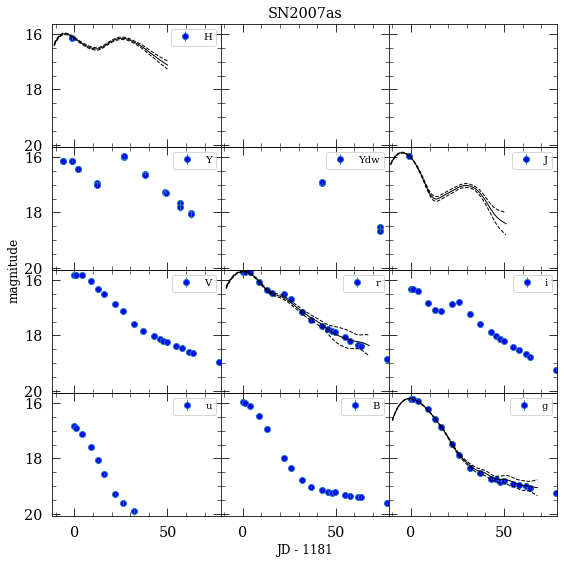

In [4]:
#DIAGRAMAS DE HUBBLE#
#####################

#Archivos de texto para el Diagrama de Hubble    
bh="resultados/"+"Hubble-allband.txt" 
with open(bh, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.6s\t%10.6s\t%10.9s\n' % ('Jmax','s.z','Nombre'))
    
bh1="resultados/"+"Hubble-grJH.txt" 
with open(bh1, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.6s\t%10.6s\t%10.9s\n' % ('Jmax','s.z','Nombre'))
    
bh2="resultados/"+"Hubble-flows.txt" 
with open(bh2, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.6s\t%10.6s\t%10.9s\n' % ('Jmax','s.z','Nombre'))
    
the_list = glob.glob('*.txt')
the_list2 = the_list[0:1].copy()
cont9=0
for a in the_list:
    cont9=cont9+1
    try:
        s = get_sn(a)
        ###Lee el archivo de la supernova
        sn=[]
        bandJ=[]
        bandH=[]
        lector(a,sn,bandJ,bandH)

        #Define bandas a estudiar
        band1=s.allbands()
        band2 = ['g', 'r', 'J', 'H']
        band3 = ['g', 'r', 'J']
        band4 = ['g', 'r', 'H']
        bands=[band1, band2]

        #Datos Hubble 1 y 2
        maxm=[]
        for i in range(len(bands)):
            s = get_sn(a)
            s.choose_model('EBV_model2', stype = 'dm15')    
            s.fit(bands[i])
            if i==0:
                sTmax = s.Tmax 
                maxJH(4,s,sTmax,maxm) #Ref no-spline
                datos(bh,0,s,6,0,0,0,0,0,maxm) #Datos para el Diagrama de Hubble allband
            else:
                maxJH(4,s,sTmax,maxm) #Ref no-spline
                datos(bh1,0,s,6,0,0,0,0,0,maxm) #Datos para el Diagrama de Hubble grJH        

        #Datos para Hubble-FLOWS
        listo=0
        j3=0
        while j3 < int(len(bandJ)*1.5):
            try:
                punto='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB0' +'_'+ a #Se busca en los txt de punto por punto con datos en J y H
                sn1,bandJ2,bandJ1,bandH1,conX=([] for i in range(5))
                lector(punto,sn1,bandJ2,bandH1)

                if float(sn1[bandJ[1]][0:7])>=(sTmax-5.0) and float(sn1[bandJ[1]][0:7])<=(sTmax+15.0): #Solo escoge el que tenga los puntos dentro del intervalo
                    j3=int(len(bandJ)*1.5)
                    s = get_sn(punto)
                    s.choose_model('EBV_model2', stype = 'dm15')    
                    s.fit(bands[1])
                    maxJH(0,s,sTmax,maxm) #punto JH
                    datos(bh2,0,s,6,0,0,0,0,0,maxm) #Datos para el Diagrama de Hubble-FLOWS
                    listo=1
                else:
                    j3=j3+1
            except:
                j3=j3+1
            
        if listo!=1:
            j3=0
            while j3 < int(len(bandJ)*1.5):
                try:
                    punto='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB1' +'_'+ a #Se busca en los txt de punto por punto con datos en J y H
                    sn1,bandJ2,bandJ1,bandH1,conX=([] for i in range(5))
                    lector(punto,sn1,bandJ2,bandH1)

                    if float(sn1[bandJ[1]][0:7])>=(sTmax-5.0) and float(sn1[bandJ[1]][0:7])<=(sTmax+15.0): #Solo escoge el que tenga los puntos dentro del intervalo
                        j3=int(len(bandJ)*1.5)
                        s = get_sn(punto)
                        s.choose_model('EBV_model2', stype = 'dm15')    
                        s.fit(band3)
                        maxJH(2,s,sTmax,maxm) #punto J
                        datos(bh2,0,s,6,0,0,0,0,0,maxm) #Datos para el Diagrama de Hubble-FLOWS
                        listo=1
                    else:
                        j3=j3+1
                except:
                    j3=j3+1

            if listo!=1:
                j3=0
                while j3 < int(len(bandH)*1.5):
                    try:
                        punto='txt/z1_2PT_'+ str(j3+1) +'_'+ 'cB2' +'_'+ a #Se busca en los txt de punto por punto con datos en J y H
                        sn1,bandJ2,bandJ1,bandH1,conX=([] for i in range(5))
                        lector(punto,sn1,bandJ2,bandH1)

                        if float(sn1[bandH[1]][0:7])>=(sTmax-5.0) and float(sn1[bandH[1]][0:7])<=(sTmax+15.0): #Solo escoge el que tenga los puntos dentro del intervalo
                            j3=int(len(bandH)*1.5)
                            s = get_sn(punto)
                            s.choose_model('EBV_model2', stype = 'dm15')    
                            s.fit(band4)
                            maxJH(3,s,sTmax,maxm) #punto H
                            datos(bh2,0,s,6,0,0,0,0,0,maxm) #Datos para el Diagrama de Hubble-FLOWS
                        else:
                            j3=j3+1
                    except:
                        j3=j3+1
                
                
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('------------FIN--------------')
        print('.')
    except:
        print('SN número',cont9,'de',len(the_list),'-','[',s.name,']')
        print('--Fallo en el ajuste--')
        print('.')

#Diagrama de Hubble
#grafhubble(bh)
#grafhubble(bh1)
#grafhubble(bh2)
print('Fin')

In [ ]:
##ANÁLISIS DE DATOS##
#####################

In [ ]:
#GRÁFICAS FLOWS Y COMBINATORIA
n1=[1,2,3,5]
for n in n1:
    if n==1:
        b="resultados/"+"sim.txt"
    else:
        b="resultados/"+"sim(n="+str(n)+").txt"
    graficas2(b,n)

In [10]:
#ANÁLISIS COMBINATORIA

#Elegir n a analizar
#n=2
#n=3
n=5

dif, difcomb, difale, dia, diacomb, diaale, jm1, jmatriz = ([] for i in range(8))
#Se obtiene la diferencia de las epocas
datoscomb(n,difcomb)
if n==2:
    datosale2(difale)
elif n==3:
    datosale3(difale)
elif n==5:
    datosale5(difale)

#Se suma el dif de ale con el de combinatoria  
dif=difale+difcomb
#print(len(difale),len(difcomb),'suma:',len(dif))

#Se obtienen las épocas medias
if n==1:
    b="resultados/"+"sim.txt"
else:
    b="resultados/"+"sim(n="+str(n)+").txt"
    c="resultados/"+"sim(n="+str(n)+")2.txt"

sim = Table.read(b, format='ascii')
for i in range(len(sim)):
        dia.append(sim[i][0])
        jm1.append(sim[i][1])
sim=[]
sim = Table.read(c, format='ascii')
for i in range(len(sim)):
        dia.append(sim[i][0])
        jm1.append(sim[i][1])

print('dia',len(dia),'dif',len(dif),'jm1',len(jm1))

#Se representa la gráfica de dispersión
grafdispersion(dia,dif,jm1,n)


#Se representa la densidad de puntos
grafdensidad(dia,dif,n)

#Se genera la matriz para el mapa de calor
matrizcalor(dia,dif,1,jmatriz)

print('FIN')

dia 77754 dif 77754 jm1 77754
FIN


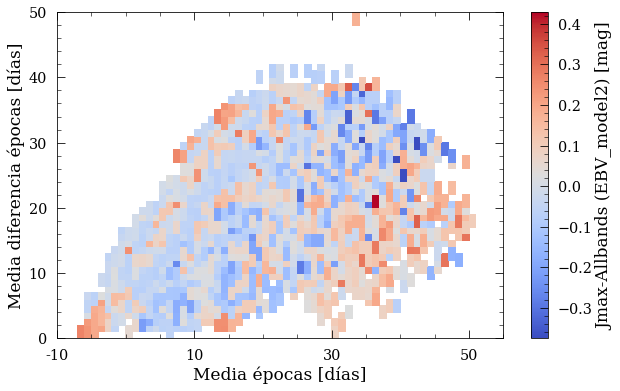

In [17]:
#Se representa el mapa de calor
#mapacalor(jmatriz,n)
plt.figure(figsize=(10,6))
plt.pcolormesh(jmatriz, cmap='coolwarm', shading='auto')

cb=plt.colorbar()
cb.set_label(label='Jmax-Allbands (EBV_model2) [mag]', fontsize=17)

plt.xlabel('Media épocas [días]', fontsize=17)
if n==2:
    plt.ylabel('Diferencia épocas [días]', fontsize=17)
else:
    plt.ylabel('Media diferencia épocas [días]', fontsize=17)

x=[0,20,40,60,80,100]
y=[0,10,20,30,40,50,60]
x1,y1=[],[]
for i in range(len(x)):
    x1.append(round(x[i]*(1)-10.))
for i in range(len(y)):
    y1.append(round(y[i]*(10/7)))
plt.xticks(x,x1)
#plt.yticks(y,y1)
plt.ylim(0,50)
plt.xlim(0,65)

plt.savefig('calor'+str(n)+'.png', dpi=500)
plt.show()
plt.close()


In [ ]:
#INTERPOLACIÓN CURVA DE LUZ MEDIA

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

# ----------------------------------------------------------------------
mediaJ="resultados/"+"mediaJ.txt" 
mediaH="resultados/"+"mediaH.txt" 

mk=5 #Tamaño puntos gráfica

#Lectura de los datos de los txt
simj = Table.read(mediaJ, format='ascii')
simh = Table.read(mediaH, format='ascii')

#Generación de vectores necesarios para graficar
epocaj,epocah,magj,magh = ([] for i in range(4))

for i in range(len(simj)):
        epocaj.append(simj[i][0])
        magj.append(simj[i][1])
for i in range(len(simh)):
        epocah.append(simh[i][0])
        magh.append(simh[i][1])

# ----------------------------------------------------------------------
# Datos banda J
X=epocaj
X = np.array(X)
X = np.atleast_2d(X).T

y=magj
y = np.array(y)
dy = 0.5 + 1.0 * np.random.random(y.shape)

minx=min(epocaj)
maxx=max(epocaj)
x = np.atleast_2d(np.linspace(minx, maxx, len(epocaj)*10)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True) #sds

#Se guardan los datos del modelo
ajusj1,ajusj2=[],[]
for i in range(len(x)):
    ajusj1.append(x[i])
    ajusj2.append(y_pred[i])
      
# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
fig, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].plot(X.ravel(), y, 'b.', markersize=mk, label='Datos')
axs[0].plot(x, y_pred, 'r-', label='Interpolación')
axs[0].fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='r', ec='None', label='Intervalo de confianza 95%')
axs[0].legend(loc='best')
axs[0].set_ylabel('Magnitud normalizada [mag]',fontsize=17) 

# ----------------------------------------------------------------------
# Datos banda H
X=epocah
X = np.array(X)
X = np.atleast_2d(X).T

y=magh
y = np.array(y)
dy = 0.5 + 1.0 * np.random.random(y.shape)

minx=min(epocah)
maxx=max(epocah)
x = np.atleast_2d(np.linspace(minx, maxx, len(epocah)*10)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

#Se guardan los datos del modelo
ajush1,ajush2=[],[]
for i in range(len(x)):
    ajush1.append(x[i])
    ajush2.append(y_pred[i])

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
axs[1].plot(X.ravel(), y, 'b.', markersize=mk, label='Datos')
axs[1].plot(x, y_pred, 'r-', label='Interpolación')
axs[1].fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.3, fc='r', ec='None', label='Intervalo de confianza 95%')
axs[1].legend(loc='best')
axs[1].set_ylabel('Magnitud normalizada [mag]',fontsize=17) 

for ax in axs.flat:
    ax.set_xlabel('Época [días]', fontsize=17)
    ax.invert_yaxis()
    
fig.tight_layout()
fig.savefig('media.png', dpi=500)
plt.show()
plt.close(fig)

In [ ]:
#DISPERSION DE LA CURVA DE LUZ MEDIA

jm13, jm12, jm22, hm13, hm12, hm22, dj1, dh1 = ([] for i in range(8))

con1=0
for i in range(94):
    for day in epocaj:
        if day>=(-14.0+float(i)) and day<=(-13.0+float(i)):
            jm13.append(magj[con1])
        con1=con1+1
    disp=np.nanstd(jm13)
    jm12.append(round(disp,3))
    jm22.append(-14.0+float(i))
    jm13=[]
    con1=0
    
con1=0
for i in range(94):
    for day in epocah:
        if day>=(-14.0+float(i)) and day<=(-13.0+float(i)):
            hm13.append(magh[con1])
        con1=con1+1
    disp=np.nanstd(hm13)
    hm12.append(round(disp,3))
    hm22.append(-14.0+float(i))
    hm13=[]
    con1=0


fig, axs = plt.subplots(1, 2, figsize=(15,5))

#axs[0].plot(jm22, jm12,'k-',label='Datos',markersize=mk)
#axs[0].plot(epocaj, dj1,'bo',label='Residuos',markersize=3)
axs[0].plot(jm22, jm12,'ro',label='σ dos días',markersize=5)
axs[0].legend(loc='best')
axs[0].set_ylabel('Dispersión en J [mag]',fontsize=17)

#axs[1].plot(hm22, hm12,'k-',label='Datos',markersize=mk)
#axs[1].plot(epocah, dh1,'bo',label='Residuos',markersize=3)
axs[1].plot(hm22, hm12,'ro',label='σ dos días',markersize=5)
axs[1].set_ylabel('Dispersión en H [mag]',fontsize=17)


for ax in axs.flat:
    ax.set_xlabel('Época', fontsize=17)
    #ax.invert_yaxis()
    
fig.tight_layout()

fig.savefig('media-disp.png', dpi=500)
plt.show()
plt.close(fig)

In [ ]:
#DISPERSION DE LOS RESIDUOS CADA 3 DÍAS

jm13, jm12, jm22, hm13, hm12, hm22, dj1, dh1 = ([] for i in range(8))
#Cálculo de los residuos (dj1,dh1) [Diferencia entre ajuste y magnitud real]
for i in range(len(magj)):
    j=0
    try:
        while round(float(ajusj1[j][0]),1)!=round(float(epocaj[i]),1):
            j=j+1
        dj1.append(float((ajusj2[j]-magj[i])))
    except:
        dj1.append(np.nan)

for i in range(len(magh)):
    j=0
    try:
        while round(float(ajush1[j][0]),1)!=round(float(epocah[i]),1):
            j=j+1
        dh1.append((float(ajush2[j]-magh[i])))
    except:
        dh1.append(np.nan)
        
##Dispersión de k días para J 
k=3.0 #días
#k2=-14.0
k2=min(epocaj)
for j in range(103):
    k1=k2+float(j)
    for i in range(len(epocaj)):
        if epocaj[i]>=k1 and epocaj[i]<k1+k:
            jm13.append(dj1[i])
    disp=np.std(jm13) 
    if len(jm13)>0:
        media=stats.mean(jm13)
    else:
        media=np.nan
    jm13=[]
    jm12.append([k1,k1+k,disp,media])
    
##Dispersión de k días para H 
k2=min(epocah)
for j in range(103):
    k1=k2+float(j)
    for i in range(len(epocah)):
        if epocah[i]>=k1 and epocah[i]<k1+k:
            hm13.append(dh1[i])
    disp=np.std(hm13) 
    if len(hm13)>0:
        media=stats.mean(hm13)
    else:
        media=np.nan
    hm13=[]
    hm12.append([k1,k1+k,disp,media])
       
#Gráfica de residuos junto a la dispersión en strip 
fig, axs = plt.subplots(1, 2, figsize=(15,5))

#axs[0].plot(jm22, jm12,'k-',label='Datos',markersize=mk)
axs[0].plot(epocaj, dj1,'bo',label='Residuos',markersize=3)
axs[0].legend(loc='best')
axs[0].set_ylabel('Dispersión en J [mag]',fontsize=17)

#axs[0].fill_between([0.0,1.0],-disp,disp,color='r',alpha=0.25)
con=int(k)
for j in range(103):
    if con==int(k):
        axs[0].errorbar((jm12[j][0]+jm12[j][1])/2,jm12[j][3],jm12[j][2],color='r')
        con=0
    con=con+1

#axs[1].plot(hm22, hm12,'k-',label='Datos',markersize=mk)
axs[1].plot(epocah, dh1,'bo',label='Residuos',markersize=3)
axs[1].set_ylabel('Dispersión en H [mag]',fontsize=17)

con=int(k)
for j in range(103):
    if con==int(k):
        axs[1].errorbar((hm12[j][0]+hm12[j][1])/2,hm12[j][3],hm12[j][2],color='r')
        con=0
    con=con+1

for ax in axs.flat:
    ax.set_xlabel('Época [días]', fontsize=17)
    #ax.invert_yaxis()
    
fig.tight_layout()

fig.savefig('media-resi.png', dpi=500)
plt.show()
plt.close(fig)

#Gráfica de residuos junto a la dispersión en strip 
fig, axs = plt.subplots(1, 2, figsize=(15,5))

#axs[0].plot(jm22, jm12,'k-',label='Datos',markersize=mk)
axs[0].plot(epocaj, dj1,'bo',label='Residuos',markersize=3)
axs[0].legend(loc='best')
axs[0].set_ylabel('Dispersión en J [mag]',fontsize=17)

#axs[0].fill_between([0.0,1.0],-disp,disp,color='r',alpha=0.25)
con=int(k)
for j in range(103):
    if con==int(k):
        axs[0].fill_between([jm12[j][0],jm12[j][1]],-jm12[j][2]+jm12[j][3],jm12[j][2]+jm12[j][3],color='r',alpha=0.25)
        axs[].hlines(jm12[j][3], xmin=jm12[j][0], xmax=jm12[j][1],color='r')
        con=0
    con=con+1

#axs[1].plot(hm22, hm12,'k-',label='Datos',markersize=mk)
axs[1].plot(epocah, dh1,'bo',label='Residuos',markersize=3)
axs[1].set_ylabel('Dispersión en H [mag]',fontsize=17)

con=int(k)
for j in range(103):
    if con==int(k):
        axs[1].fill_between([hm12[j][0],hm12[j][1]],-hm12[j][2]+hm12[j][3],hm12[j][2]+hm12[j][3],color='r',alpha=0.25)
        axs[1].hlines(hm12[j][3], xmin=hm12[j][0], xmax=hm12[j][1],color='r')
        con=0
    con=con+1
#axs[1].hlines(0.4, 0, 5)
for ax in axs.flat:
    ax.set_xlabel('Época [días]', fontsize=17)
    #ax.invert_yaxis()
    
fig.tight_layout()

fig.savefig('media-resi2.png', dpi=500)
plt.show()
plt.close(fig)

In [ ]:
#MISCELÁNEA#
############

In [ ]:
#OBTENER LOS DATOS PARA AJUSTAR MANUALMENTE LOS SPLINE#
#######################################################
a='SN2007le_snpy.txt'

ale1, ale2, ale, diaJ, diaH, datosJ, datosH, pdf = ([] for i in range(8))
a1, a2, a3, a4 = ([] for i in range(4))

s = get_sn(a)
name =str(s.name)
tipos=['data','model','smooth','model_grJH']

for tipo in tipos: #Matriz con datos para J/H (1er panel)
    dmp1='txt/'+name[4:]+'_lc_J_'+tipo+'.dat'
    dmp2='txt/'+name[4:]+'_lc_H_'+tipo+'.dat'
    try:
        ale = Table.read(dmp1, format='ascii')
        ale1.append(ale)
        if tipo=='model':
            pdf=ale.copy()            
    except:
        for k1 in range(len(pdf)):
            for k2 in range(len(pdf[k1])):
                pdf[k1][k2]=np.nan
        ale1.append(pdf)
    pdf=[]                       
    ale=[]
    try:
        ale = Table.read(dmp2, format='ascii')
        ale2.append(ale)
        if tipo=='model':
            pdf=ale.copy()  
    except:
        for k1 in range(len(pdf)):
            for k2 in range(len(pdf[k1])):
                pdf[k1][k2]=np.nan
        ale2.append(pdf)

for i in [1,3]: #Se recorren las matrices para borrar las comas generadas por dump_lc
    try:
        for j in range(len(ale1[i])):
            for k in range(3):
                    ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
    except:
        pass
    try:
        for j in range(len(ale2[i])):
            for k in range(3):
                    ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
    except:
        pass    
for i in range(4):
    for j in range(len(ale1[i])):
        a1.append(float(ale1[i][j][0]))
        a2.append(float(ale1[i][j][1]))
    for k in range(len(ale2[i])):
        a3.append(float(ale2[i][k][0]))
        a4.append(float(ale2[i][k][1]))
    diaJ.append(a1) #matrices necesarias para graficar
    datosJ.append(a2)
    diaH.append(a3)
    datosH.append(a4)
    a1, a2, a3, a4 = ([] for i in range(4))
    
a11, a22, a33, a44 = ([] for i in range(4))
diaJ1, diaH1, datosJ1, datosH1 = ([] for i in range(4))

diaJ1=diaJ[0].copy()
datosJ1=datosJ[0].copy()
diaH1=diaH[0].copy()
datosH1=datosH[0].copy()

print('fin')

In [ ]:
#CODIGO PARA AJUSTAR MANUALMENTE
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

dJ, daJ = [], []

j=2
if j==1: #H
    for i in range(len(diaH1)):
        media1=mean(diaH1)
        media2=mean(datosH1)
        dJ.append((-mean(diaH1)+diaH1[i])/10)
        daJ.append((-mean(datosH1)+datosH1[i])/10)

elif j==2: #J
    for i in range(len(diaJ1)):
        media1=mean(diaJ1)
        media2=mean(datosJ1)
        dJ.append((-mean(diaJ1)+diaJ1[i])/10)
        daJ.append((-mean(datosJ1)+datosJ1[i])/10)

        
x = np.atleast_2d(np.linspace(min(dJ), max(dJ), int((max(dJ)-min(dJ))*200))).T 
#x = np.atleast_2d(np.linspace(min(dJ), 3.0029473684210872, int((3.0029473684210872-min(dJ))*200))).T 
#print(dJ)


                
X = np.atleast_2d(dJ).T
y = np.atleast_2d(daJ).T

# Instantiate a Gaussian Process model
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
#kernel = C(1, (1, 1)) * RBF(1, (3, 3))
kernel = C(1, (1, 1)) * RBF(1, (2.8, 2.8)) ########################################################## kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

print(min(y_pred))
print(min(y_pred)*10+media2)

#Grafica para ajustar manualmente
plt.figure(figsize=(10,6))
plt.ylabel('Range J $[mag]$', fontsize=17)
plt.xlabel('Época', fontsize=17)


plt.plot(X, y, 'r.', markersize=10, label='Datos')
plt.plot(x, y_pred, 'b-', label='Interpolación')
plt.gca().invert_yaxis()

plt.legend(loc='upper right')
plt.show()
plt.close()

#Para guardar la gráfica
plt.figure(figsize=(10,6))
if j==1:
    plt.ylabel('Range H [magnitud]', fontsize=17)
    plt.xlabel('Época [MJD]', fontsize=17)
    plt.plot(diaH1, datosH1, 'r.', markersize=10, label='Datos')
elif j==2:
    plt.ylabel('Range J [magnitud]', fontsize=17)
    plt.xlabel('Época [MJD]', fontsize=17)
    plt.plot(diaJ1, datosJ1, 'r.', markersize=10, label='Datos')
plt.plot(x*10+media1, y_pred*10+media2, 'b-', label='Interpolación')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.savefig('Overleaf/'+'interpolacion.png', dpi=500)
plt.show()
plt.close()


#Reescribe el txt de dump_lc
k=0
if k==1:
    if j==1:
        b='txt/'+name[4:]+'_lc_H_'+'smooth'+'.dat'
        with open(b, 'w') as f:
            f.write('%10.17s\n' % ('# column 1:  time'))
            f.write('%10.30s\n' % ('# column 2:  splined magnitude'))
            for l in range(len(y_pred)):
                primer=x[l][0]*10+mean(diaH1)
                segundo=y_pred[l][0]*10+mean(datosH1)
                f.write('%10.5f\t%10.5f\n' % (primer,segundo))
            print('fin')
    elif j==2:
        b='txt/'+name[4:]+'_lc_J_'+'smooth'+'.dat'
        with open(b, 'w') as f:
            f.write('%10.17s\n' % ('# column 1:  time'))
            f.write('%10.30s\n' % ('# column 2:  splined magnitude'))
            for l in range(len(y_pred)):
                primer=x[l][0]*10+mean(diaJ1)
                segundo=y_pred[l][0]*10+mean(datosJ1)
                f.write('%10.5f\t%10.5f\n' % (primer,segundo))
            print('fin')

In [ ]:
#CODIGO PARA LA GRAFICA QUE MUESTRA LAS 6 REFERENCIAS#
######################################################

#a='SN2006X_snpy.txt'
#j1=0

#a='SN2005el_snpy.txt'
#j1=36

a='SN2007le_snpy.txt'
j1=33

s = get_sn(a)

band1=s.allbands()
band2 = ['g', 'r']
band3 = ['g', 'r', 'J', 'H']

band4 = ['g', 'r', 'J']
band5 = ['g', 'r', 'H']
#Defino una lista de bandas general que contiene a las listas anteriores
bands=[band1, band2, band3]

for i in range(len(bands)):
    s = get_sn(a)
    s.choose_model('max_model', stype = 'dm15') 
    print(i)                
    if i<1:
        s2 = get_sn(a)
        s2.choose_model('max_model', stype = 'dm15') #Ref de allband ajuste en max_model
        s2.fit(bands[i])
        sTmax = s.Tmax 
        dump(3,s2,band1,0)

    elif i>1:
        s3 = get_sn(a)
        s3.choose_model('max_model', stype = 'dm15') #Ref de grJH ajuste en max_model
        s3.fit(bands[i])
        dump(4,s3,band1,0)


ale1, ale2, ale, diaJ, diaH, datosJ, datosH = ([] for i in range(7))
a1, a2, a3, a4 = ([] for i in range(4))

#------------------------------------------------------

name =str(s.name)
tipos=['data','model','smooth','model_grJH'] 

for tipo in tipos: #Matriz con datos para J/H (1er panel)
    dmp1='txt/'+name[4:]+'_lc_J_'+tipo+'.dat'
    dmp2='txt/'+name[4:]+'_lc_H_'+tipo+'.dat'
    ale = Table.read(dmp1, format='ascii')
    ale1.append(ale)
    ale=[]
    ale = Table.read(dmp2, format='ascii')
    ale2.append(ale)

for i in [1,3]: #Se recorren las matrices para borrar las comas generadas por dump_lc
    try:
        for j in range(len(ale1[i])):
            for k in range(3):
                    ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
    except:
        pass
    try:
        for j in range(len(ale2[i])):
            for k in range(3):
                    ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
    except:
        pass    
for i in range(len(tipos)):
    for j in range(len(ale1[i])):
        a1.append(float(ale1[i][j][0]))
        a2.append(float(ale1[i][j][1]))
    for k in range(len(ale2[i])):
        a3.append(float(ale2[i][k][0]))
        a4.append(float(ale2[i][k][1]))
    diaJ.append(a1) #matrices necesarias para graficar
    datosJ.append(a2)
    diaH.append(a3)
    datosH.append(a4)
    a1, a2, a3, a4 = ([] for i in range(4))
    
tipos=['data','model','smooth','model_grJH']  
ale1, ale2, ale, diaJ1, diaH1, datosJ1, datosH1 = ([] for i in range(7))
a1, a2, a3, a4 = ([] for i in range(4))    

for tipo in tipos: #Matriz con datos para J/H (1er panel)
    dmp1='txt/'+name[4:]+'_lc_J_'+tipo+'_max.dat'
    dmp2='txt/'+name[4:]+'_lc_H_'+tipo+'_max.dat'
    ale = Table.read(dmp1, format='ascii')
    ale1.append(ale)
    ale=[]
    ale = Table.read(dmp2, format='ascii')
    ale2.append(ale)

for i in [1,3]: #Se recorren las matrices para borrar las comas generadas por dump_lc
    try:
        for j in range(len(ale1[i])):
            for k in range(3):
                    ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
    except:
        pass
    try:
        for j in range(len(ale2[i])):
            for k in range(3):
                    ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
    except:
        pass    
for i in range(len(tipos)):
    for j in range(len(ale1[i])):
        a1.append(float(ale1[i][j][0]))
        a2.append(float(ale1[i][j][1]))
    for k in range(len(ale2[i])):
        a3.append(float(ale2[i][k][0]))
        a4.append(float(ale2[i][k][1]))
    diaJ1.append(a1) #matrices necesarias para graficar
    datosJ1.append(a2)
    diaH1.append(a3)
    datosH1.append(a4)
    a1, a2, a3, a4 = ([] for i in range(4))

fig, axs = plt.subplots(1, 2, figsize=(14,6))

axs[0].plot(diaJ[0], datosJ[0], 'bo', label='data') 
axs[0].plot(diaJ[1], datosJ[1], 'r',linewidth=1.2, label='Allband (EBV_model2)') 
axs[0].plot(diaJ[3], datosJ[3], 'lime',linewidth=1.2, label='grJH(EBV_model2)')
axs[0].plot(diaJ1[1], datosJ1[1], 'm',linewidth=1.2, label='Allband (max_model)') 
axs[0].plot(diaJ1[3], datosJ1[3], 'c',linewidth=1.2, label='grJH (max_model)')
axs[0].plot(diaJ[2], datosJ[2], 'k',linewidth=1.2, label='spline') 
axs[0].invert_yaxis()
axs[0].legend(loc='best')
axs[0].set_ylabel('Range J [magnitud]',fontsize=17)
axs[0].set_xlabel('Época [MJD]',fontsize=17)

axs[1].plot(diaH[0], datosH[0], 'bo', label='data') 
axs[1].plot(diaH[1], datosH[1], 'r',linewidth=1.2, label='Allband (EBV_model2)') 
axs[1].plot(diaH[3], datosH[3], 'lime',linewidth=1.2, label='grJH (EBV_model2)') 
axs[1].plot(diaH1[1], datosH1[1], 'm',linewidth=1.2, label='Allband (max_model)') 
axs[1].plot(diaH1[3], datosH1[3], 'c',linewidth=1.2, label='grJH (max_model)') 
axs[1].plot(diaH[2], datosH[2], 'k',linewidth=1.2, label='spline') 
axs[1].invert_yaxis()
axs[1].set_ylabel('Range H [magnitud]',fontsize=17)
axs[1].set_xlabel('Época [MJD]',fontsize=17)

if j1!=0:
    ##### Punto por punto
    ale1, ale2, ale, diaJ, diaH, datosJ, datosH, conj, conh = ([] for i in range(9))
    conj1,conh1=0,0
    for i in range(j1): #Matriz con datos para J/H punto por punto 
        dmp1='txt/'+name[4:]+'_lc_J_model_'+str(i)+'.dat'
        dmp2='txt/'+name[4:]+'_lc_H_model_'+str(i)+'.dat'
        try:
            ale = Table.read(dmp1, format='ascii')
            ale1.append(ale)
            conj.append(0)
            conj1=conj1+1
        except:
            conj.append(1)
            ale1.append([0,0,0])
        ale=[]
        try:
            ale = Table.read(dmp2, format='ascii')
            ale2.append(ale)
            conh.append(0)
            conh1=conh1+1
        except:
            conh.append(1)
            ale2.append([0,0,0])
    for i in range(j1): #Se recorren las matrices para borrar las comas generadas por dump_lc
        try:
            for j in range(len(ale1[i])):
                for k in range(3):
                        ale1[i][j][k]=float(str(ale1[i][j][k]).replace(",", ""))
        except:
            pass
        try:
            for j in range(len(ale2[i])):
                for k in range(3):
                        ale2[i][j][k]=float(str(ale2[i][j][k]).replace(",", ""))
        except:
            pass
    for i in range(j1): #Se ordenan los datos en distintas matrices
        if conj[i]!=1:
            for j in range(len(ale1[i])):
                a1.append(float(ale1[i][j][0]))
                a2.append(float(ale1[i][j][1]))
            diaJ.append(a1) 
            datosJ.append(a2)
        if conh[i]!=1:
            for k in range(len(ale2[i])):
                a3.append(float(ale2[i][k][0]))
                a4.append(float(ale2[i][k][1]))
            diaH.append(a3)
            datosH.append(a4)
        a1, a2, a3, a4 = ([] for i in range(4))

    cl='Grey'
    #vector de colores para cambiarlo en cada n

    for i in range(conj1):
        axs[0].plot(diaJ[i], datosJ[i], str(cl), alpha=0.22)
    for i in range(conh1):
        axs[1].plot(diaH[i], datosH[i], str(cl), alpha=0.22)


fig.tight_layout()
fig.savefig('Overleaf/'+str(name)+'-fit.jpeg', dpi=500)
plt.close(fig)
print('FIN')

In [ ]:
#GRÁFICA DE RANGO DE BANDAS#
############################

bandas=['u','B','g','V','r','i','J','H']
color=['m','b','g','k','r','maroon','crimson','navy']

plt.figure(figsize=(14,6))
plt.xlabel('Longitud de onda $[A]$',fontsize=22)
plt.ylabel('Transmisión normalizada',fontsize=22)    


ale, ale1, x, y, y2 = ([] for i in range(5))
for i in range(len(bandas)): #Matriz con datos para J/H (1er panel)
    bnd='Overleaf/'+bandas[i]+'.dat'
    ale = Table.read(bnd, format='ascii')

    for j in range(len(ale)):
        x.append(float(ale[j][0]))
        y.append(float(ale[j][1]))
        y2.append(0)
    plt.plot(x, y, color[i], markersize=10, label=bandas[i])
    plt.fill_between(x,y,y2,alpha=0.2)
    ale, ale1, x, y, y2 = ([] for i in range(5))
    
plt.text(32*100, 0.2, bandas[0], color=color[0], fontsize=25)
plt.text(42*100, 0.2, bandas[1], color=color[1], fontsize=25)
plt.text(45*100, 0.45, bandas[2], color=color[2], fontsize=25)
plt.text(51*100, 0.2, bandas[3], color=color[3], fontsize=25)
plt.text(61*100, 0.2, bandas[4], color=color[4], fontsize=25)
plt.text(75*100, 0.2, bandas[5], color=color[5], fontsize=25)

plt.text(123*100, 0.2, bandas[6], color=color[6], fontsize=25)
plt.text(160*100, 0.2, bandas[7], color=color[7], fontsize=25)
 
#plt.legend(loc='best')
plt.ylim(0,)
plt.tight_layout()
#plt.show()
plt.savefig("Overleaf/Bandas.jpeg", dpi=500)
plt.close()
print('fin')

In [ ]:
#CONTADOR DE SIMULACIONES#
##########################

the_list = glob.glob('*.txt')
con=0
con2=0
for a in the_list:
    s = get_sn(a)
    sn=[]
    bandJ=[]
    bandH=[]
    lector(a,sn,bandJ,bandH)
    #pdis=min([len(bandJ)-1,len(bandH)-1])
    pdis=min([len(bandJ),len(bandH)])
    #if pdis>2 and pdis<30:
    for i in [5]:
        if (pdis-i)>0:
            n2=int((np.math.factorial(pdis)/(np.math.factorial(i)*np.math.factorial(pdis-i))))
            con2=n2+con2

print('---')        
print(con2)

In [ ]:
#TABLA DATOS SNe Ia#
####################

tsn="Overleaf/"+"tablaSN.txt" 
with open(tsn, 'w') as f:#primera línea con el nombre de los datos de cada columna
    f.write('%10.9s\t%10.6s\t%10.6s\t%10.6s\t%10.9s\n' % ('Nombre','z','ra','dec','filtros'))

#final='\\\\ \hline' 
final='\\\\'    
    
the_list = glob.glob('*.txt')
the_list2 = sorted(the_list)
con=0
for a in the_list2:
    s = get_sn(a)
    
    bandas1=s.allbands()
    bandas=''
    for i in range(len(bandas1)):
        bandas=bandas+bandas1[i]
    borrar=['dw','rc2','0']
    for i in range(len(borrar)):
        try:
            bandas=bandas.replace(borrar[i],'')
        except: pass
    try:
        bandas=bandas.replace('YY','Y')
    except: pass
    bandas=' '+bandas    
    with open(tsn, 'a') as f:
        f.write('%10.9s\t%10.5s%10.5f\t%10.5s%10.5f\t%10.5s%10.5f\t%10.5s%10.22s\t%10.10s\n' % (s.name,'&',s.z,'&',s.ra,'&',s.decl,'&',bandas,final))
    con=con+1
    print(con,'de',len(the_list))
    
print('FIN')